# Encoder-decoder: мост от RNN к трансформерам

Прогресс не стоит на месте и сейчас почти все лучшие модели машинного обучения используют под капотом другую архитектуру — transformer. 

Прежде чем приступить к разбору архитектуры трансформера, важно понять, как он появился. На появление трансформера повлияли три ключевые вещи:

- seq2seq-задача;

- encoder-decoder архитектура;

- механизм внимания в encoder-decoder архитектуре.

## Seq2Seq-задачи

В машинном обучении особое место занимают задачи, где и вход, и выход являются последовательностями переменной длины. Такие задачи называются sequence-to-sequence (seq2seq). Это важный класс задач, для которых не подходит простая классификация или регрессия, поскольку длина выходной последовательности заранее неизвестна и зависит от входа.

Примеры seq2seq-задач:

- Машинный перевод: вход — «I am a student», выход — «Я студент».
  
- Распознавание речи (speech-to-text): аудиосигнал (последовательность признаков) превращается в текст.
  
- Обобщение текста (summarization): вход — длинный текст, выход — краткое содержание.
  
- Генерация кода: вход — описание задачи, выход — сгенерированный код.
  
- Диалоговые агенты: вход — вопрос, выход — ответ.

Это далеко не все возможные примеры, seq2seq-задачи встречаются повсеместно.

Важно отметить, что не всякая NLP-задача является seq2seq. Например, классификация отзывов — это задача с фиксированным выходом (метка класса), она не требует генерации последовательности. Переменная длина и входа, и выхода — это единственное необходимое и достаточное условие, по которому можно определить seq2seq-задачу.

## Как выглядит датасет в seq2seq

В отличие от задач классификации, в seq2seq модель обучается по парам: "input_text" → "target_text".
Например:
```
"where is the bank?" → "wo ist die Bank?"
"good morning" → "guten Morgen" 
```
На этапе препроцессинга тексты преобразуются в токены:

- input_ids — токены входа (например, ["where", "is", "the", "bank", "?"]);

- target_ids — токены выхода (например, ["wo", "ist", "die", "Bank", "?"]).

>Таргет — это тоже последовательность токенов. 

Поэтому при генерации ответа можно рассматривать задачу как последовательное решение нескольких задач классификации: предсказание первого токена, второго и так далее. 

Это позволяет использовать функции потерь, как и для обычной классификации. 
Обычно используется кросс-энтропия.


## Архитектура encoder-decoder

Seq2seq-задачи сложно решать с помощью обычных RNN: они не очень хорошо справляются с длинными последовательностями. Эта проблема возникает и при генерации текста: чем больше текста RNN генерирует, тем сильнее она забывает о входной последовательности. Поэтому для решения seq2seq-задач были предложены специальные архитектуры — encoder-decoder.

>Суть архитектуры encoder-decoder в том, что она состоит из двух частей — кодировщика (encoder) и декодера (decoder).

## Encoder (кодировщик)

>Обрабатывает входную последовательность и формирует скрытое состояние — сжатое представление всей входной информации.


Пример: для текста "You know nothing, John Snow", encoder читает слова по порядку, итоговое скрытое состояние содержит информацию обо всём предложении.
В разных источниках Encoder может называться по-разному. Возможны варианты «кодировщик», «енкодер», «энкодер».

В этом уроке чаще будет использоваться слово «энкодер» или английский вариант “encoder“.

## Decoder (декодер)

>Генерирует выходную последовательность по шагам. На каждом шаге:

1. Получает скрытое состояние от предыдущего шага. На нулевом шаге используется скрытое состояние, полученное после чтения энкодером входной последовательности.
   
2. Берёт предыдущий сгенерированный токен. На нулевом шаге используется специальный токен `<eos>`, означающий начало последовательности.
    
3. Считает новое скрытое состояние, применяет к нему линейный слой, предсказывает следующее слово, которое нужно сгенерировать.

Верхнеуровнено:


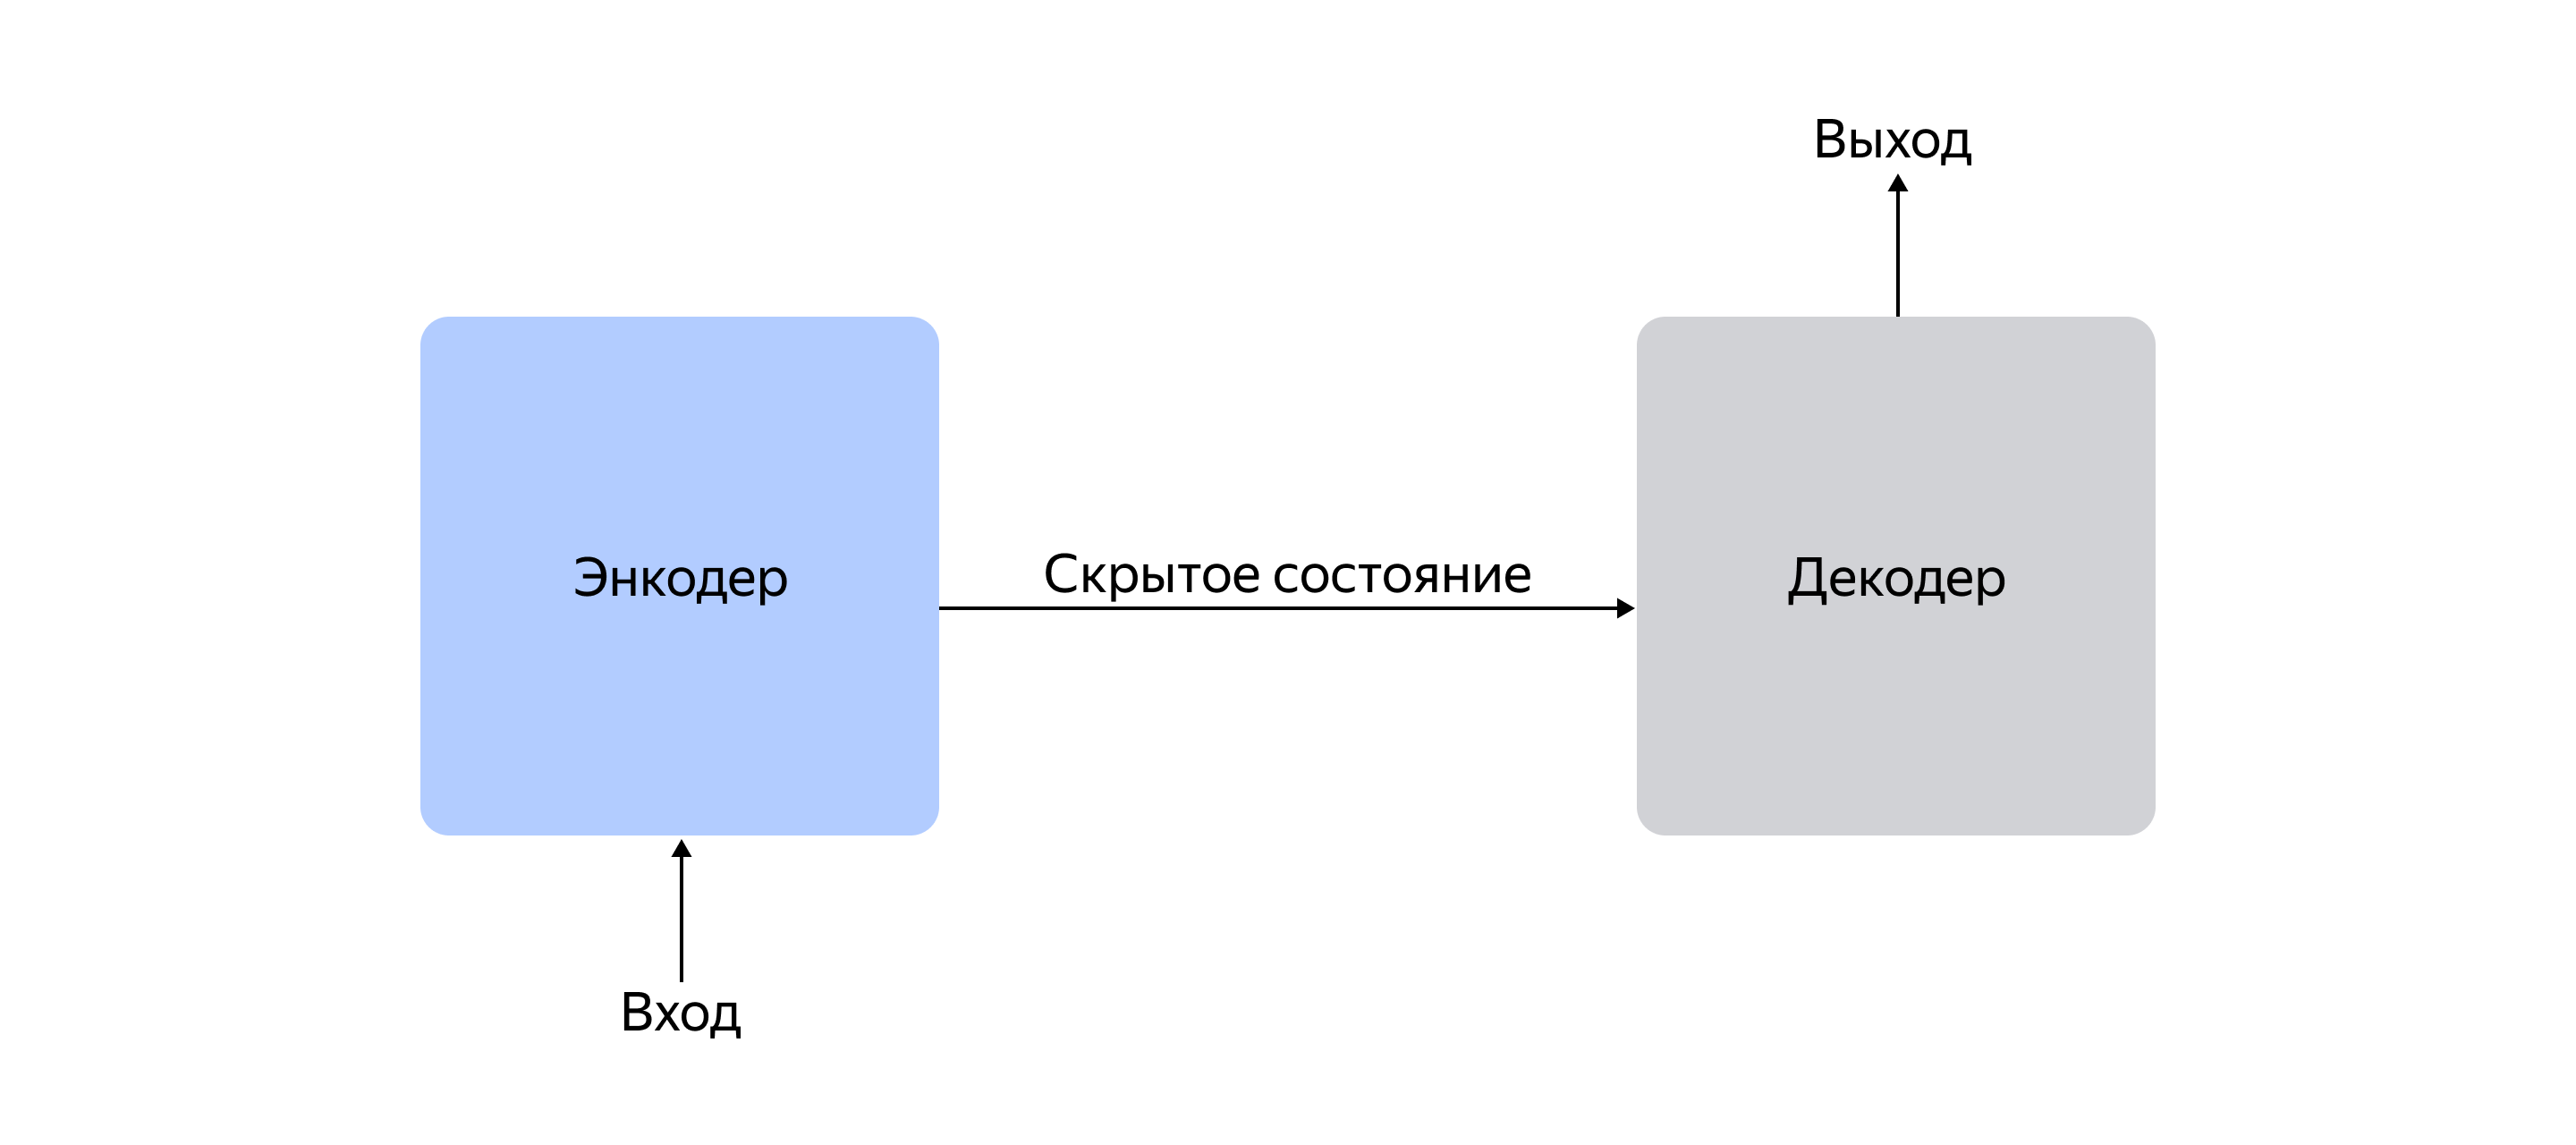

In [5]:
from IPython.display import Image
from ml_dl_experiments.settings import settings

path_to_summ = settings.SOURCE_PATH + "ml_dl/RNN/encoder_decoder_upper.png"
path_to_decomposition = settings.SOURCE_PATH + "ml_dl/RNN/encoder_decoder_decomposition.png"

Image(path_to_summ, width=700, height=1000)

Если мы декомпозируем, то увидим RNN в обоих случаях:

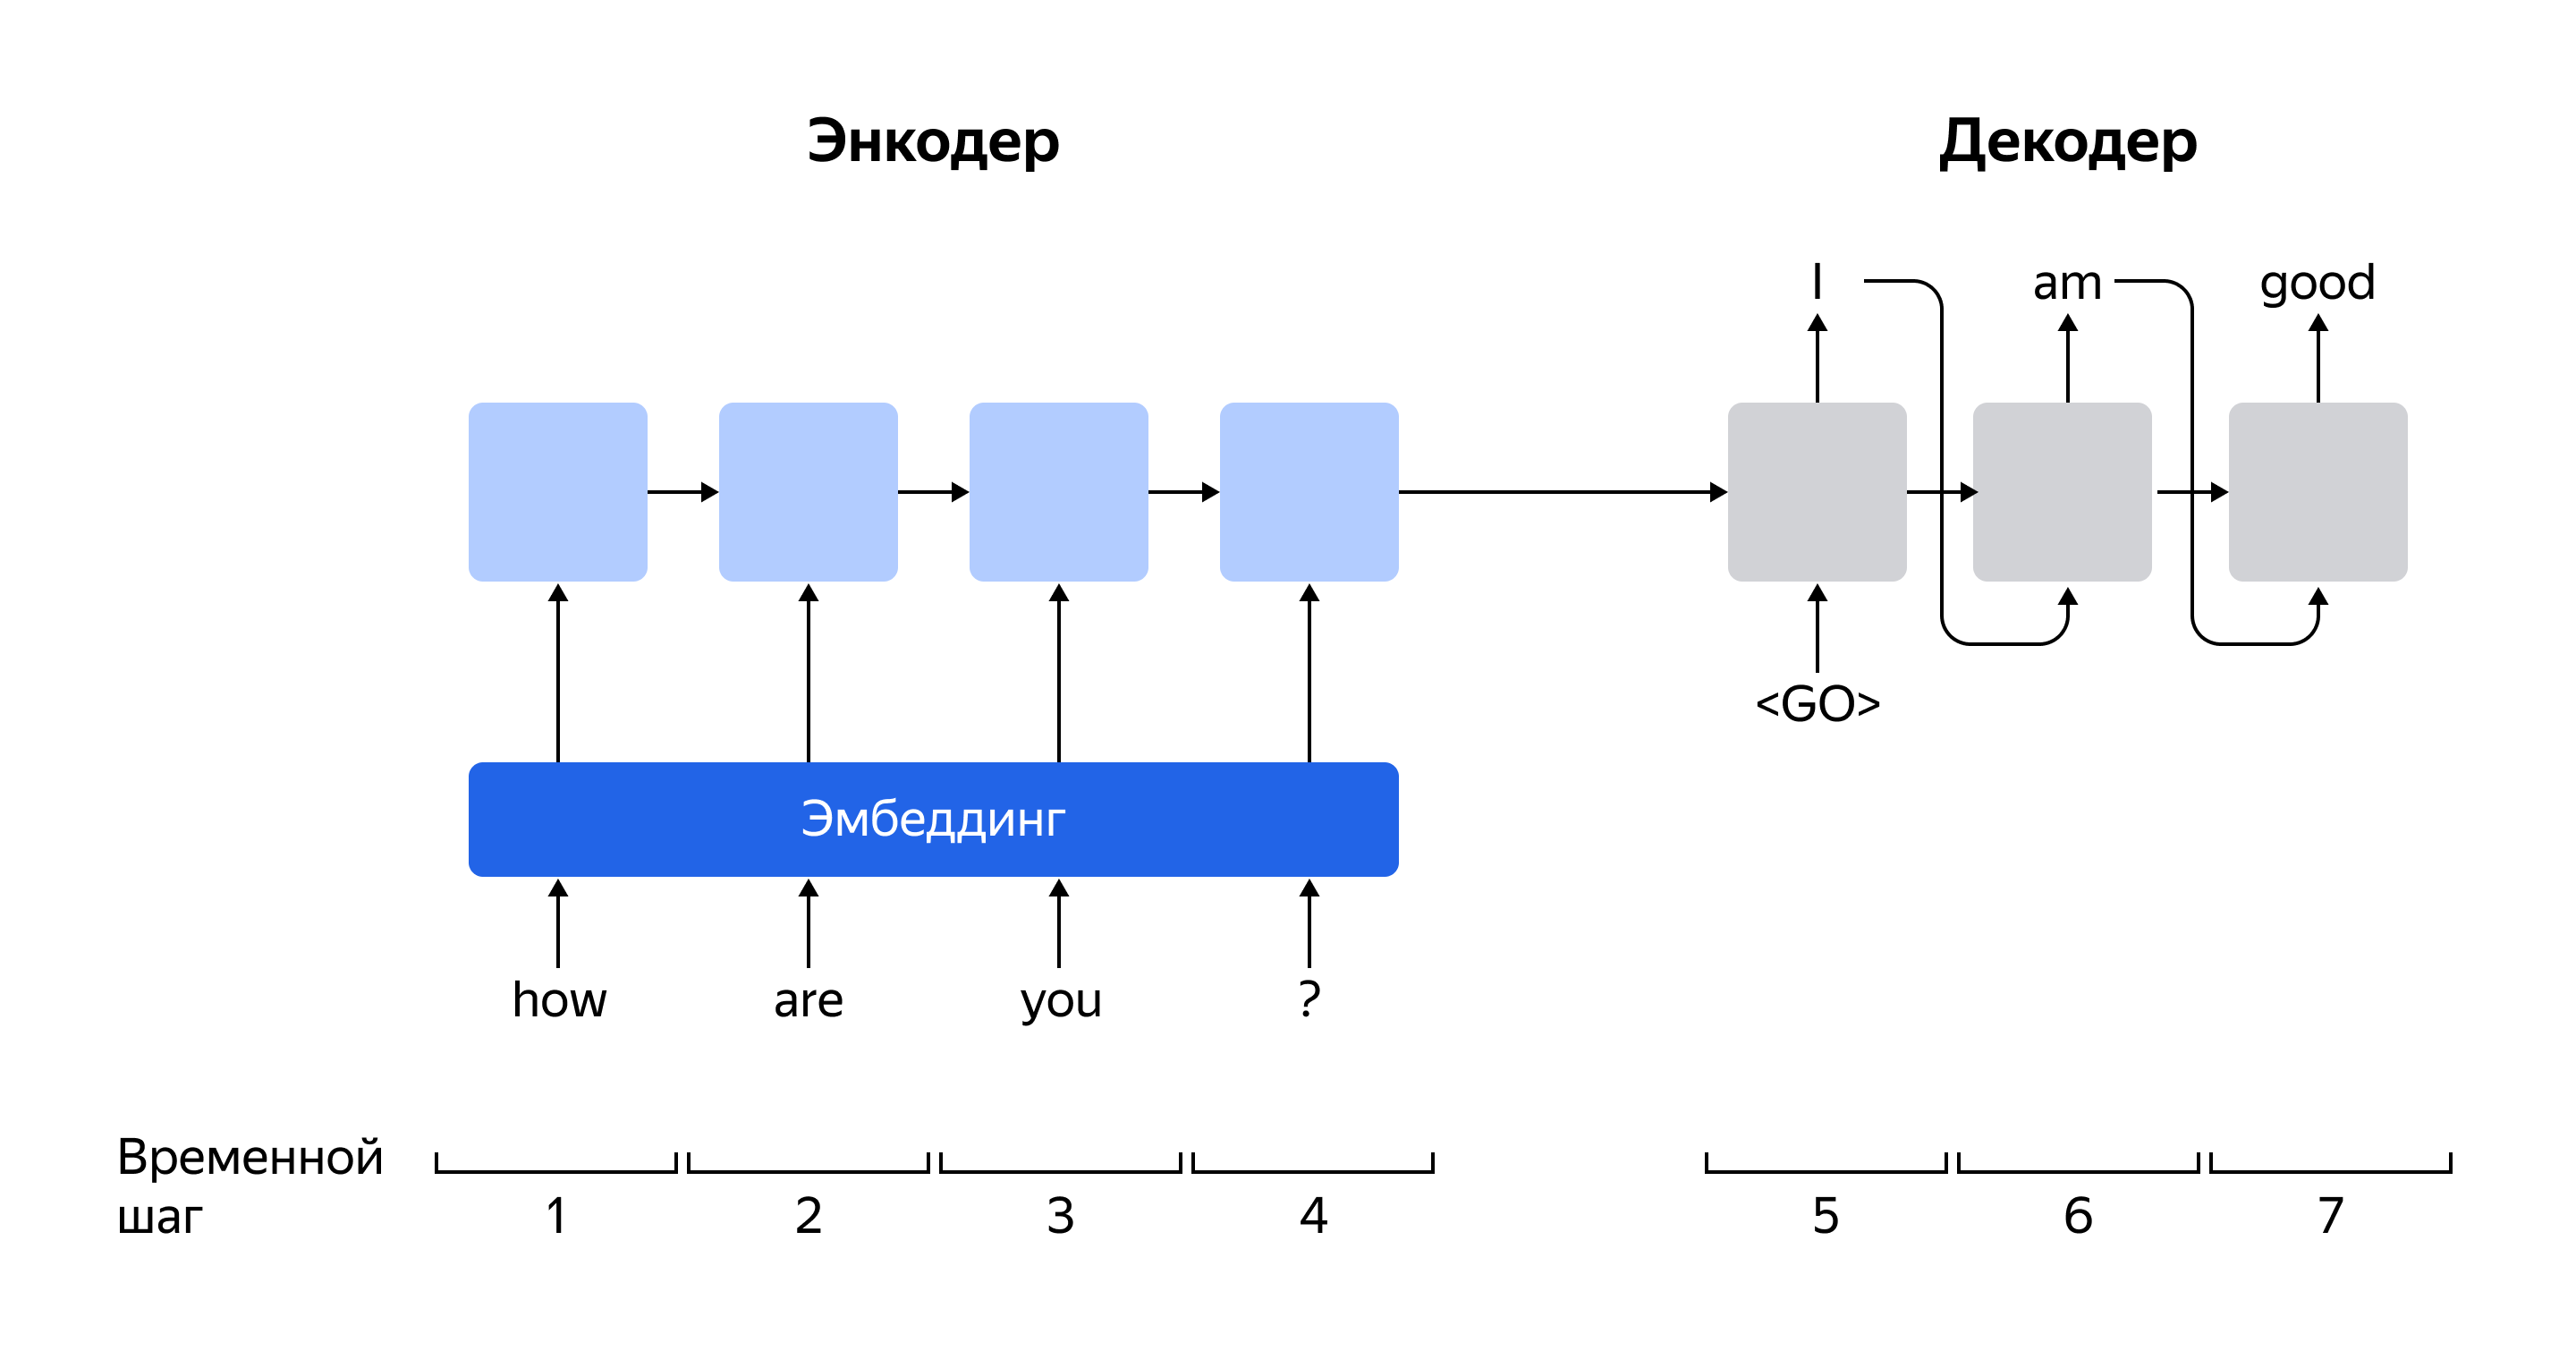

In [6]:
Image(path_to_decomposition, width=700, height=1000)

## Механизм внимания (Attention)

Обычная encoder-decoder архитектура с рекуррентными сетями имеет одно проблемное место — передача скрытого состояния от энкодера к декодеру. Один вектор скрытого состояния от энкодера не может содержать всю информацию при длинных входах, его может быть просто недостаточно, чтобы сгенерировать необходимо хорошую выходную последовательность. Это ограничивает производительность и качество модели.

Для решения этой проблемы был придуман механизм внимания. Это часть архитектуры, позволяющая декодеру на каждом шаге смотреть на всю входную последовательность, а не только на скрытое состояние, посчитанное энкодером по всему входу. Механизм вычисляет веса внимания (attention weights), которые определяют важность каждого токена входа на данном шаге генерации.

### Как это работает

На каждом шаге декодера:

1. Скрытое состояние, посчитанное декодером, скалярно перемножается со всеми скрытыми состояниями из энкодера.

2. На основе посчитанных произведений принимается решение, какие токены из входной последовательности важны, чтобы сгенерировать выход на этом шаге, а какие нет. Происходит вычисление весов внимания (обычно это softmax, применённый к произведениям скрытых состояний).

3. На основе посчитанных весов внимания считается взвешенная сумма всех скрытых состояний из энкодера и получается контекстный вектор (context vector).
    
4. К контекстному вектору применяется линейный слой и softmax, чтобы предсказать, какое слово сгенерировать следующим.

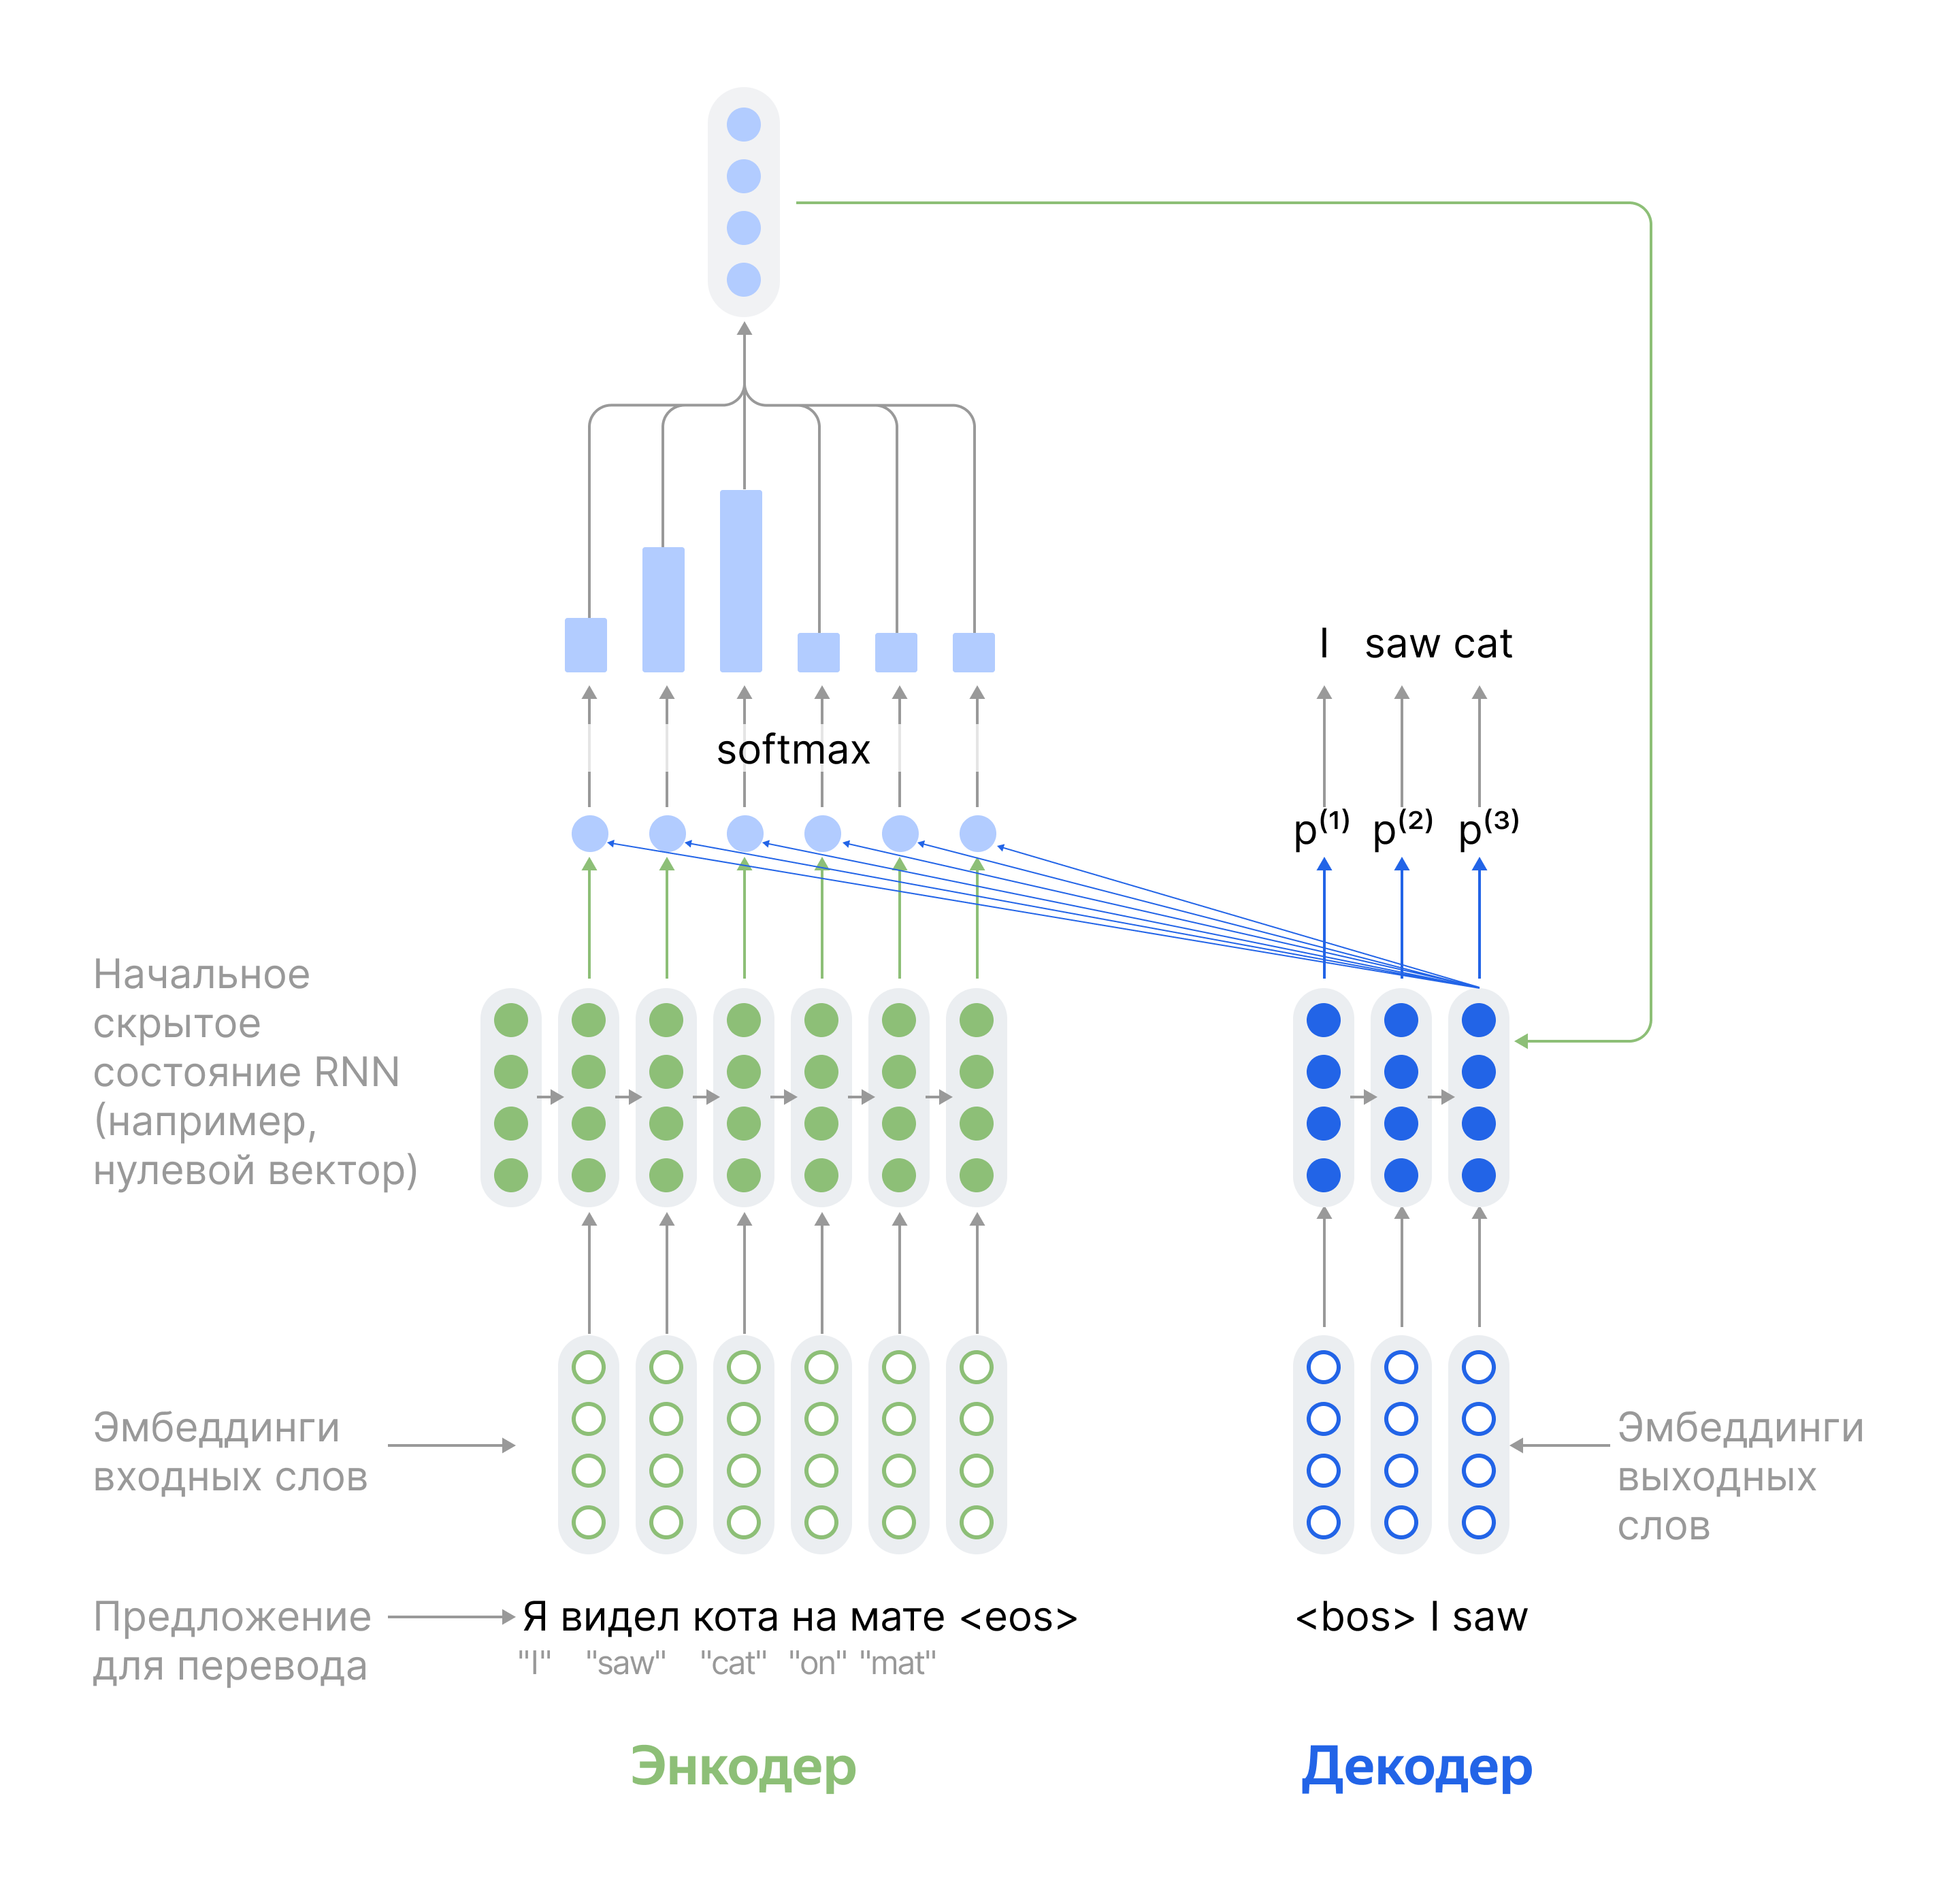

In [3]:
from IPython.display import Image
from ml_dl_experiments.settings import settings

path_to_image: str = settings.SOURCE_PATH + "ml_dl/RNN/transformer.png"

Image(path_to_image, width=700, height=1000)

1. На предыдущем шаге $t−1$ модель решила, что хочет сгенерировать слово "saw". Теперь надо сгенерировать следующее слово. На вход рекуррентный блок декодера получает входной вектор $x_t$​ (токен "saw") и скрытое состояние из предыдущего шага $h_{t−1}$​.

2. По входу $x_t$​ и предыдущему скрытому состоянию $h_{t−1}$​ рекуррентный блок рассчитывает новое скрытое состояние $h_t$​. Здесь пока нет механизма внимания и всё как в обычных рекуррентных сетях.

3. Теперь, имея скрытое состояние $h_t$​, модель хочет «понять», на какие токены из входной последовательности следует обратить внимание для генерации выхода. Для этого считаются скалярные произведения $h_t$​ со всеми скрытыми состояниями из энкодера (обозначим их как $h_{enc,1}​,h_{enc,2}​,...,h_{enc,n}$​):

$w_1​=h_t​⋅h_{enc,1}​$
$w_2​=h_t​⋅h_{enc,2}​$
$...$
$w_n​=h_t​⋅h_{enc,n}​$

Чтобы веса внимания отражали свой смысл, их надо превратить в распределение вероятностей. Тогда токены, на которых стоит обратить особое внимание, будут иметь большой вес, а бесполезные — маленький, и все значения будут от 0 до 1.

$w_1​,w_2​,..,w_n​=softmax([w_1​,w_2​,..,w_n​])$

В нашем примере скрытое состояние энкодера, посчитанное для слова «кот», должно иметь наибольший вес (потому что после слова «видел, — "saw" модель будет переводить слово «кот»).

4. Далее, все скрытые состояния энкодера складываются с посчитанными весами внимания:

context_vector=$w_1​h_{enc,1}​+w_2​h_{enc,2}​+...+w_n​h_{enc,n}​$

Получается контекстный вектор размера hidden_dim.

5. К контекстному вектору применяется линейный слой и softmax, чтобы понять, какое слово генерировать следующим:
    
next_word=$argmax(softmax(Lvocab_size,hidden_dim​⋅context_vector))$

В нашем случае next_word это токен, соответствующий слову "cat".

## Где применять attention

Механизм внимания — это универсальный метод дать модели возможность использовать максимум информации из входного текста, чтобы наиболее качественно сгенерировать новый текст. Поэтому attention будет полезен при решении любой seq2seq-задачи.

Но когда речь идёт не о seq2seq-задачах, то механизм внимания там будет лишним. Применение attention'а не имеет смысла в классической задаче классификации, регрессии и любой другой, где выход — фиксированная длина.

# Введение в трансформеры

Трансформер повторяет тот же общий принцип, что и классическая энкодер-декодер архитектура для решения seq2seq-задач: входная последовательность сначала преобразуется энкодером, а затем декодер, используя это представление, поэтапно генерирует выход.

У трансформера есть несколько отличий от своих предшественников:

- **Он работает параллельно**. Рекуррентные сети обрабатывают последовательности шаг за шагом, а трансформер смотрит на всю последовательность сразу и использует в вычислениях все входные токены параллельно.

- **Он опирается не на скрытые состояния, а на attention-механизмы внимания**. Attention в трансформерах не совсем такой, как в энкодер-декодер архитектуре с RNN, но во многом повторяет идеи, описанные там. Принято считать, что attention между энкодером и декодером в архитектуре с RNN является родоначальником attention'а, используемого в трансформерах.

>Благодаря этим деталям трансформер полностью лишён проблемы долгосрочного запоминания и может отлично учитывать взаимосвязи даже между дальними токенами в последовательности.

И энкодер, и декодер трансформера состоят из нескольких одинаковых блоков, соединённых последовательно. Поэтому иногда говорят, что энкодер — это на самом деле последовательность энкодеров, а декодер — последовательность декодеров. Каждый блок энкодера обрабатывает входную последовательность и передаёт результат следующему блоку. То же самое происходит с декодером. Все блоки одинаковы по структуре, но имеют разные параметры. Обычно используется до 10–15-ти блоков в энкодере и столько же в декодере:

На рисунке ниже схема работы трансформера, похожая на предыдущую — только один блок энкодера заменен на несколько последовательных, и с декодером то же самое. От одного блока энкодера идет несколько стрелок ко всем блокам декодера.
Благодаря такой архитектуре:

- Модель учится обобщать информацию на разных уровнях

- Каждый блок может захватывать разные аспекты взаимосвязей между токенами входной и выходной последовательности.

Так как архитектурно все блоки энкодера/декодера одинаковы, то и входные и выходные параметры у них должны иметь одинаковый формат?

- Пусть $x_1​,x_2​,...,x_{seq_len}​$ — последовательность эмбеддингов токенов входной последовательности.
    
- Пусть размер каждого равен hidden_size.

- Тогда вся последовательность представима в виде матрицы размера (seq_len,hidden_size).

- В таком случае блок энкодера, принимающий на вход такую матрицу, на выходе будет выдавать матрицу такого же размера (seq_len,hidden_size).

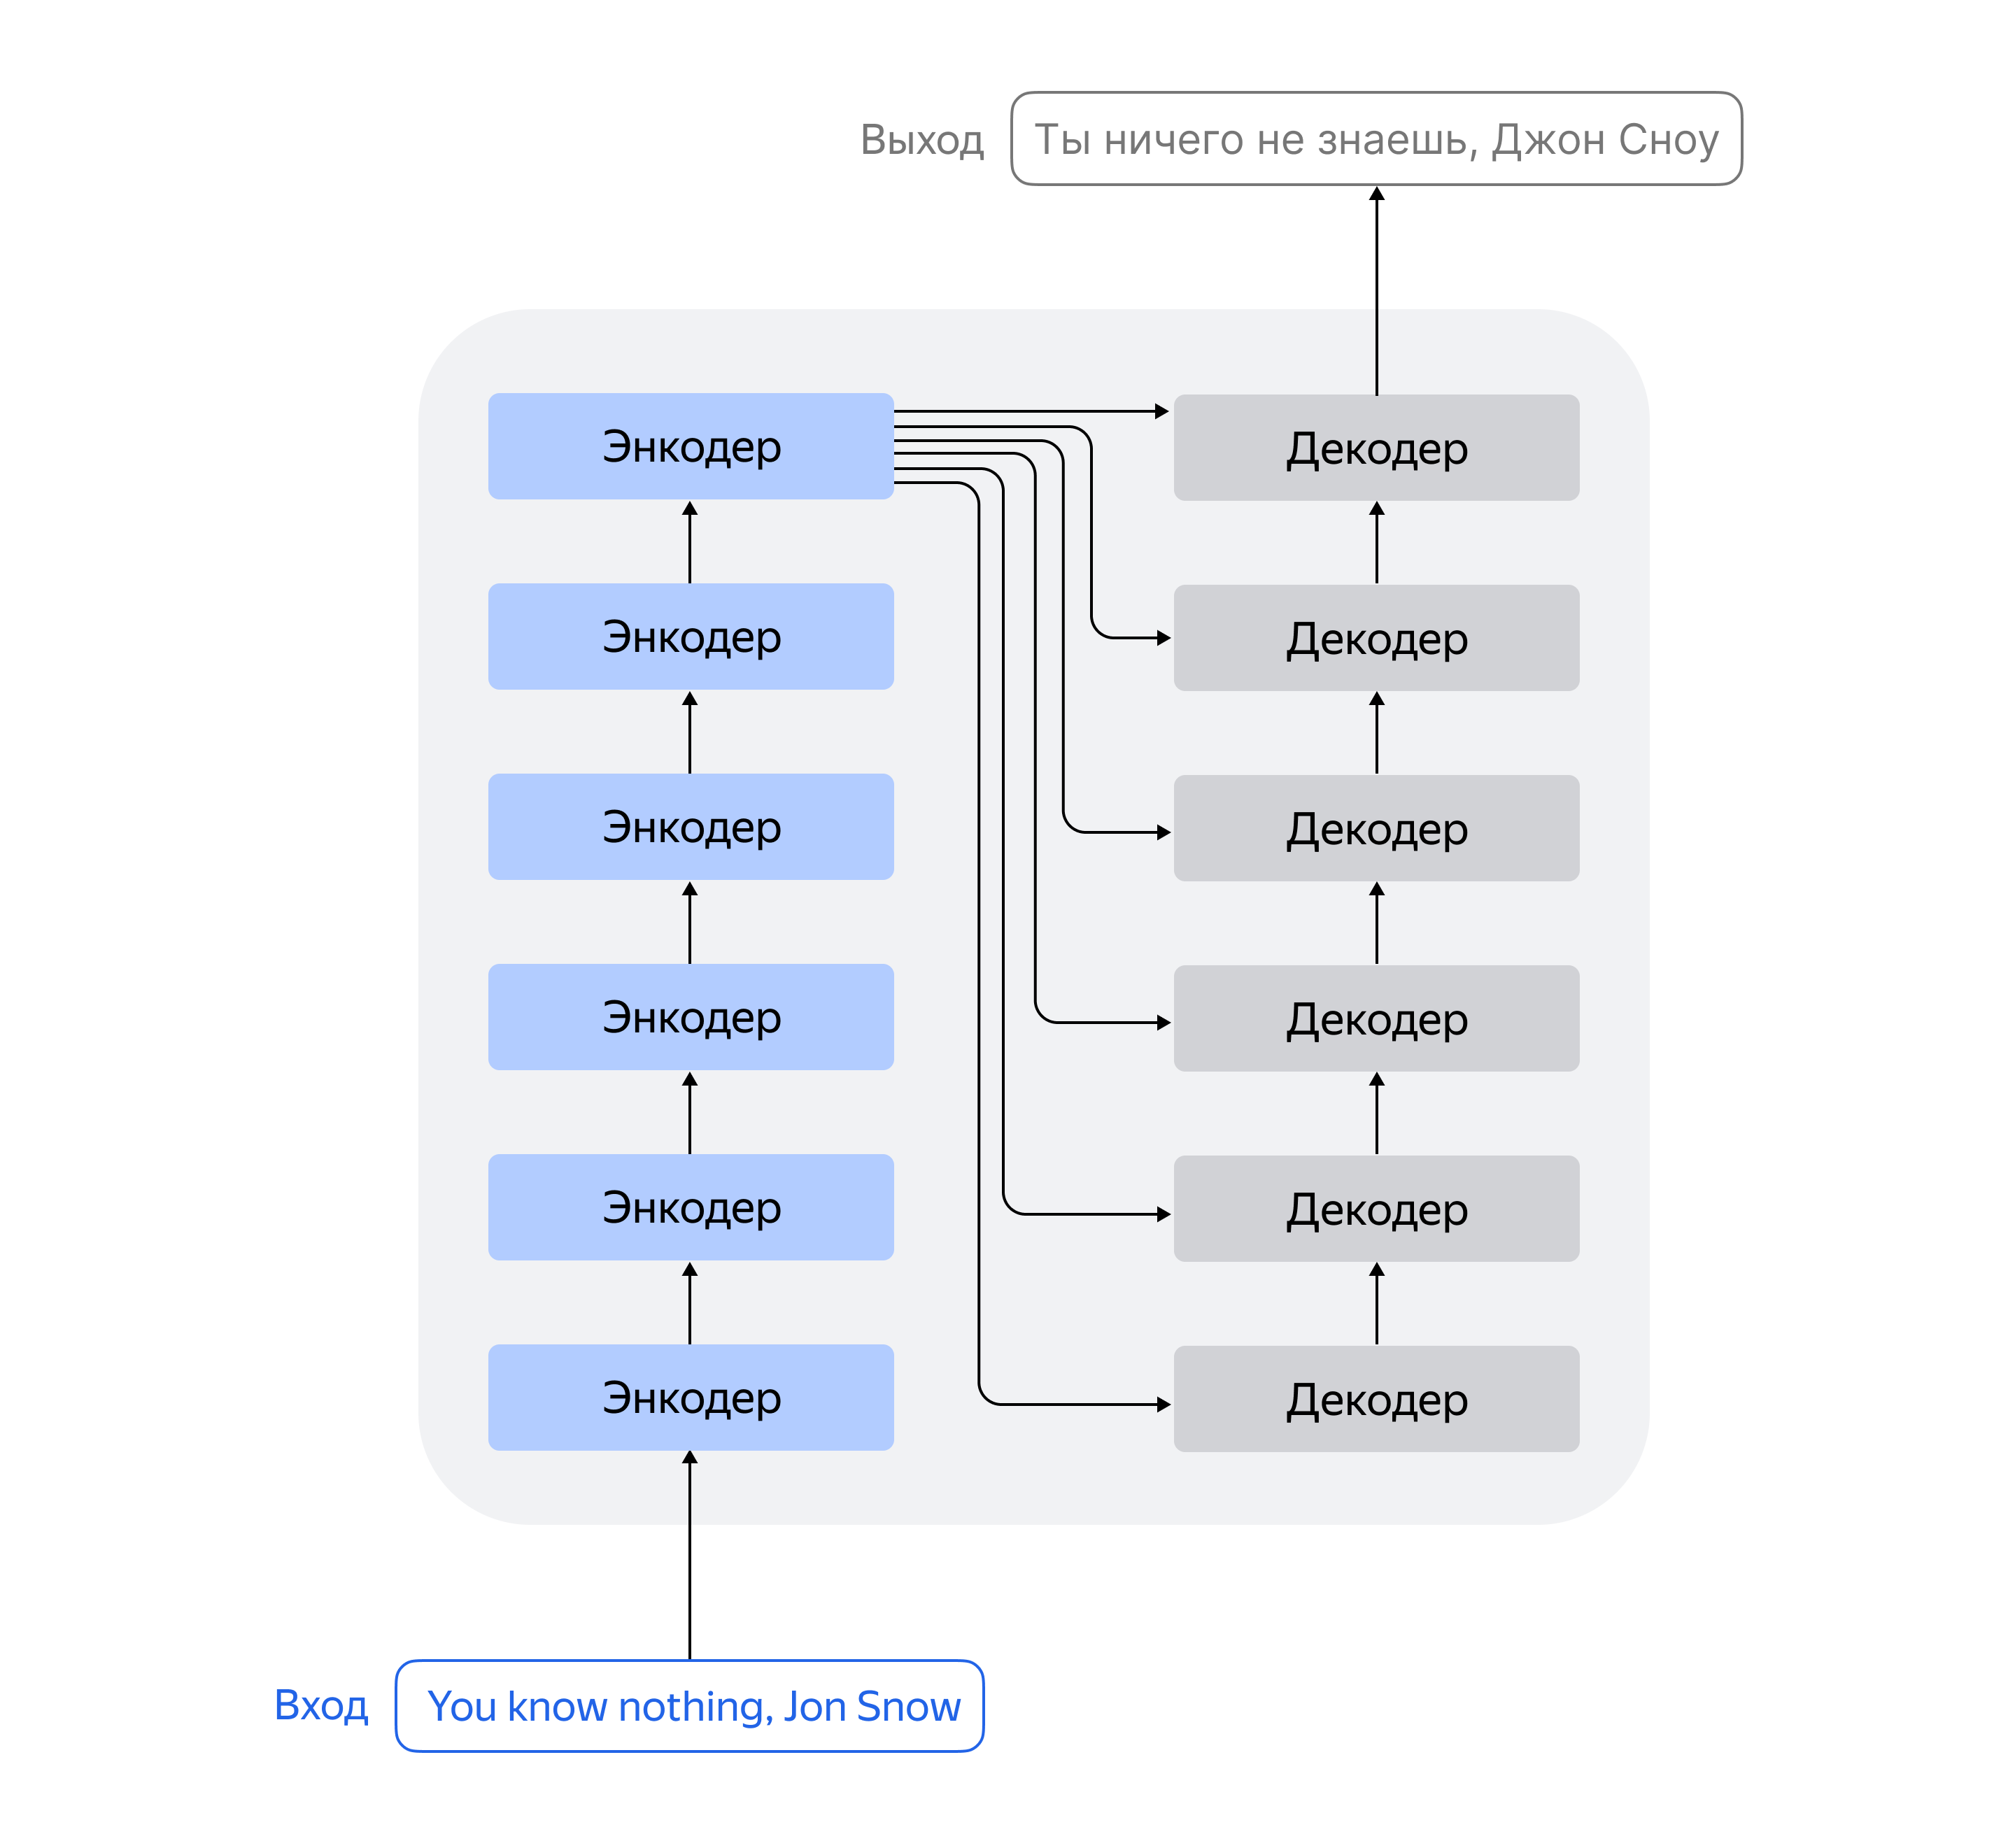

In [4]:
path_to_image: str = settings.SOURCE_PATH + "ml_dl/RNN/transformer2.png"

Image(path_to_image, width=700, height=1000)

## Энкодер и self-attention

Теперь, когда верхнеуровневое устройство понятно, будем переходить к деталям. Начнём с энкодера — разберём, как устроен один его блок.

### Компоненты блока энкодера

Один блок энкодера состоит из двух основных компонент:

- Self-attention — механизм, который позволяет каждому токену учитывать другие токены в последовательности. Этот механизм «видит» данные из всей входной последовательности и избавляет модель от необходимости читать вход шаг за шагом, как это было в RNN.
    
- Feedforward-сеть (полносвязная сеть) — обычная нейросеть из линейных слоёв, применяемая к каждому токену отдельно.

Каждый блок также содержит:

- Нормализацию (LayerNorm) перед/после каждой части. Она позволяет избежать деградации градиентов. С нормализацией вы знакомы из уроков по стабилизации обучения нейросетей.

- Остаточные соединения (Residual connections). Они нужны, чтобы сохранить информацию из предыдущего шага. Идея остаточных соединений очень проста: вместо того чтобы просто прогонять вход X через слой нейросети SubLayer и получать выход, к выходу поэлементно прибавляется и сам вход, а уже только после этого применяется нормализация:

$Output=LayerNorm(X+SubLayer(X))$

Это нужно, чтобы модель не теряла исходную информацию, если следующие блоки (например, self-attention или линейные слои) временно ухудшают представление. Иными словами, если один из слоёв делает «глупость», остаточное соединение спасает ситуацию, сохраняя то, что уже было.

Эта простая идея сильно помогает глубоким моделям сходиться быстрее и быть более устойчивыми.

### Как работает self-attention

Self-attention принимает на вход список векторов фиксированного размера для токенов входной последовательности. Это могут быть эмбеддинги или полученные на предыдущих шагах представления. Обозначим размеры этих представлений как d. Таким образом, вход X — это матрица размера (seq_len,d).

Теперь self-attention должен для каждого токена посчитать его взаимодействия с другими токенами из входной последовательности и сохранить это в весах модели.

Для этого каждому токену сопоставляется три вектора:

 - $Query (Q)$ — что я ищу?
 - $Key (K)$ — какие характеристики есть у других токенов?
 - $Value (V)$ — какую информацию они несут?

Сопоставление делается очень просто — внутри модели есть отдельные веса (WQ,WK,WV) для каждого типа векторов. И чтобы получить соответствующие матрицы Q, K, V, нужно умножить вход X на эти веса:

$Q=XW_Q$
$K=XW_K$
$V=XW_V$

Далее, для каждого токена вычисляется вес внимания к остальным токенам:
$$
Attention(Q,K,V)=softmax(\frac{QK^T}{\sqrt(d)}​V)
$$

Что значит эта формула:

- С помощью скалярного произведения вектора $Q$ (запрос) для конкретного токена на векторы $K$ (ключи) всех остальных токенов, модель как бы спрашивает: «Как конкретный токен с ключом $Q$ связан с другими векторами в последовательности?». Матрицы $Q, K$ имеют размер (seq_len,d), а матрица $QK^T$ — размер (seq_len,seq_len). То есть для каждого токена в последовательности она будет хранить seq_len посчитанных значений, отражающих взаимосвязь этого токена с остальными.
    
- Последующее умножение на матрицу $V$ и расчёт $softmax$ — по сути агрегация знаний обо всех векторах с учётом посчитанных ранее весов.

### Связь с классическим attention'ом между энкодером и декодером

Нетрудно провести аналогию с классическим attention'ом, разобранным в предыдущем уроке. Матричное произведение $QK^T$ — это расчёт весов внимания (в классическом attention'е это были скалярные произведения скрытых состояний из RNN), а умножение на $V$ — это как взвешенная сумма скрытых состояний энкодера.

В результате применения self-attention'а, для каждого токена получается новый вектор, в котором учтён контекст всех остальных слов. И выход self-attenton'а имеет размер (seq_len,d) — такой же, как и у входа, что позволяет удобно использовать его в последующих слоях и использовать Residual connection.

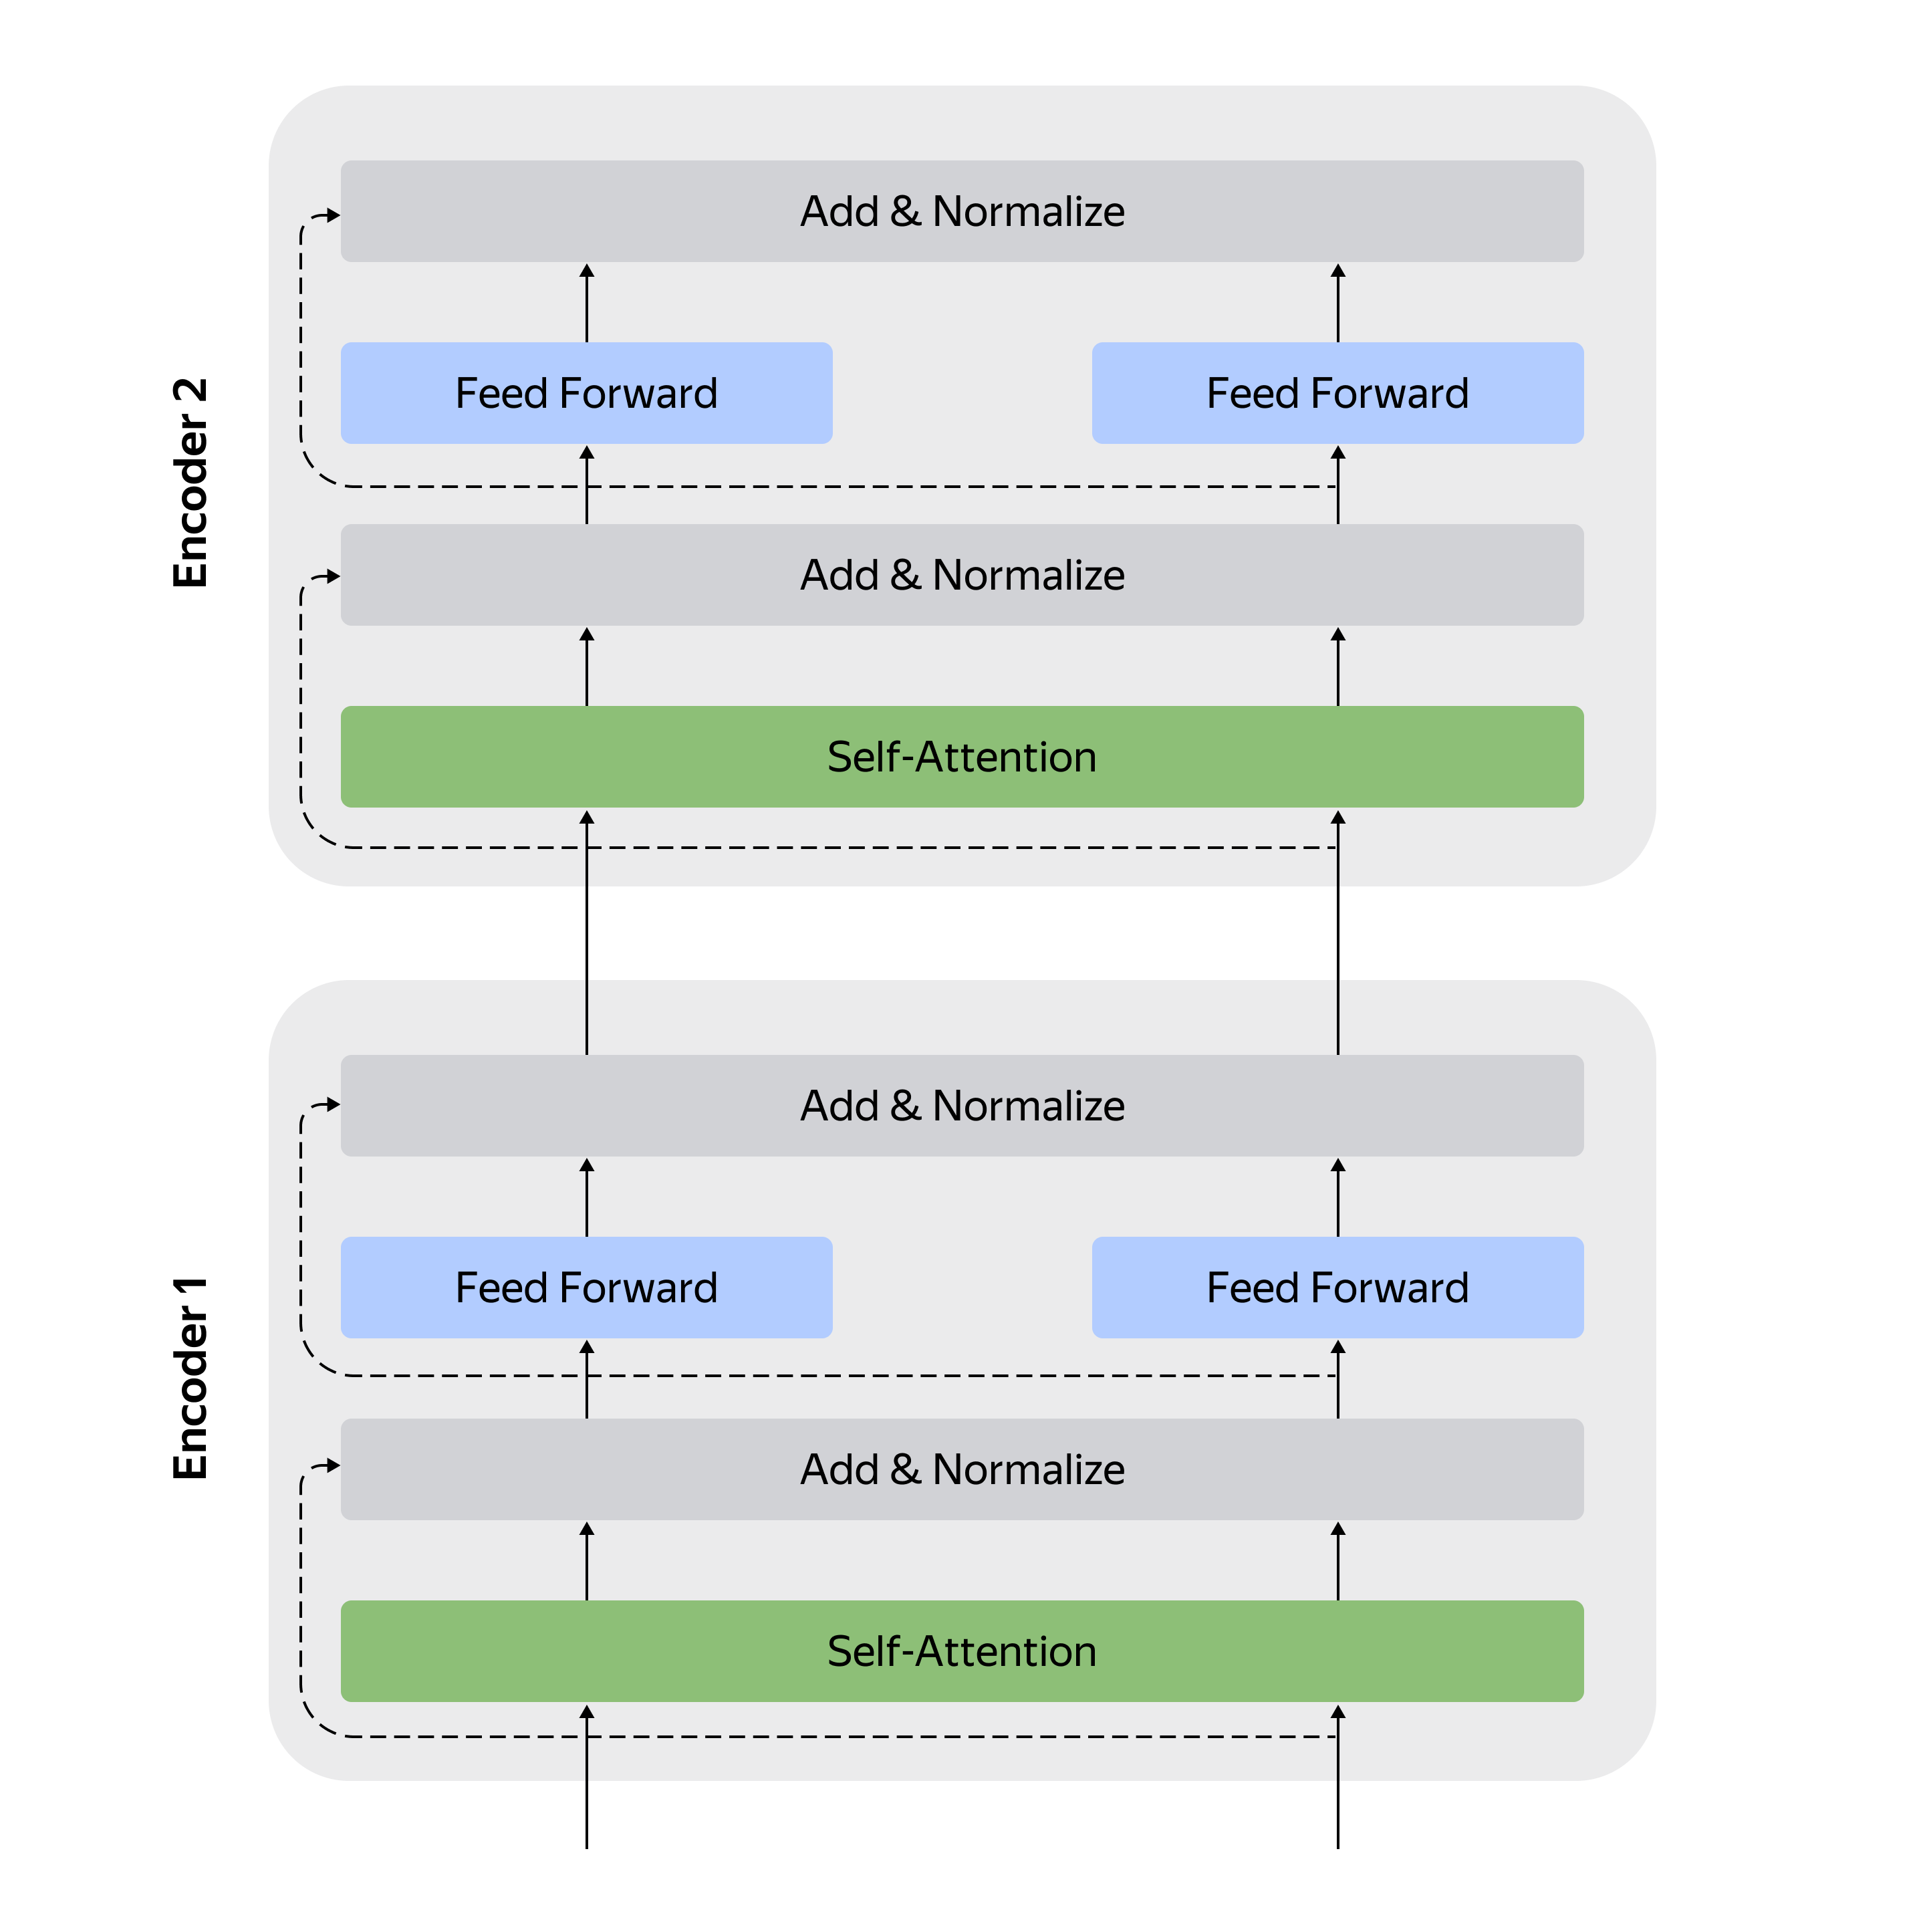

In [5]:
path_to_image: str = settings.SOURCE_PATH + "ml_dl/RNN/transformer3.png"

Image(path_to_image, width=700, height=1000)

В каждом блоке к представлениям входных токенов применяется self-attention, затем — residual connection и нормализация. После этого — линейный слой + residual connection + нормализация. И так последовательность представлений входных токенов проходит шаг за шагом через блоки энкодера.

## Учёт расположения токенов: positional encoding

Self-attention — мощный механизм, но он нечувствителен к порядку токенов. Если поменять местами слова, результат будет тем же, потому что attention сравнивает токены между собой, но не знает, в каком они порядке пришли.

В RNN эта проблема решалась архитектурно — модель читала последовательность и обрабатывала токены по порядку. Но в трансформеры надо явно добавить информацию о порядке. Для этого в архитектуре используется позиционное кодирование (positional encoding). Эта часть архитектуры позволяет модели отличать первый токен от последнего, даже без рекурсии.

### Как это делается

В самом начале к эмбеддингу токена $x_i​$ прибавляется позиционный вектор $p_i​$. Вектор $p_i​$ хранит в себе информацию о позиции в последовательности.
$$
z_i​=x_i​+p_i​
$$

Тем самым каждый токен получает знание о своём расположении во входной последовательности.

В качестве вектора pi​ можно использовать фиксированные значения:

$p_{i,2j}​=sin(\frac{pos​}{10000^{2j/d}})$

$p_{i,2j+1}​=cos(\frac{pos​}{10000^{2j/d}})$

где:

 - $pos$ — позиция токена (0, 1, 2, ...);
 - $i$ — индекс измерения внутри вектора (0, 1, ..., d/2−1);
 - $d$ — размерность эмбеддинга (например, 512).

Тогда вектор $p_i​=(p_{i,0}​,p_{i,1}​,...)$

Такой метод называется синусоидальным кодированием. Он:

 - Не требует обучения.
 
 - Периодические функции позволяют обобщать на более длинные последовательности.

Альтернатива — обучаемое позиционное кодирование. Вместо формул, позиции задаются как обычные эмбеддинги и обучаются вместе с моделью. 

Создаётся матрица весов P размера (seq_len,d) и прибавляется к входным представлениям в самом начале модели ещё до первого блока энкодера. Так мы даём модели выучить использование позиций токенов самой.

## Декодер и механизм внимания между энкодером и декодером

Главная задача декодера — генерировать новую последовательность токен за токеном. Декодер в трансформере также состоит из нескольких одинаковых блоков, каждый из них содержит три ключевых компонента.

### Структура одного блока декодера

Каждый блок состоит из следующих слоёв (в порядке применения):

1. **Masked Self-Attention**. На момент генерации очередного токена модель не должна видеть будущие токены. Например, при генерации 3-го токена она может использовать только 1-й и 2-й. Поэтому первый слой каждого декодера — это self-attention как в энкодере, но с маской: матрица внимания заполняется -inf значениями в позициях, соответствующих будущим токенам, а затем к ней применяется softmax. В результате модель может учиться генерировать по одному токену за раз.

2. **Encoder-Decoder Attention.** Именно в этой части декодер использует информацию, полученную из текста энкодером. После masked self-attention у нас есть промежуточное представление сгенерированных токенов. Теперь модель должна обратить внимание на входную последовательность. Для этого считается такой же attention с матрицами Q, K, V, но матрицы K и V здесь используются не новые, а из последнего блока энкодера. Это похоже на передачу скрытого состояния от одной RNN к другой, только здесь передаются матрицы из механизма внимания. Это позволяет модели cвязать текущий генерируемый токен с конкретной частью входа.

3. **Feedforward-сеть (FFN)**. В конце блока к полученным векторным представлениям генерируемых токенов применяется линейный слой.

Также вокруг каждого слоя, как и в энкодере, используется Residual connection и нормализация.

Вот как это всё выглядит:

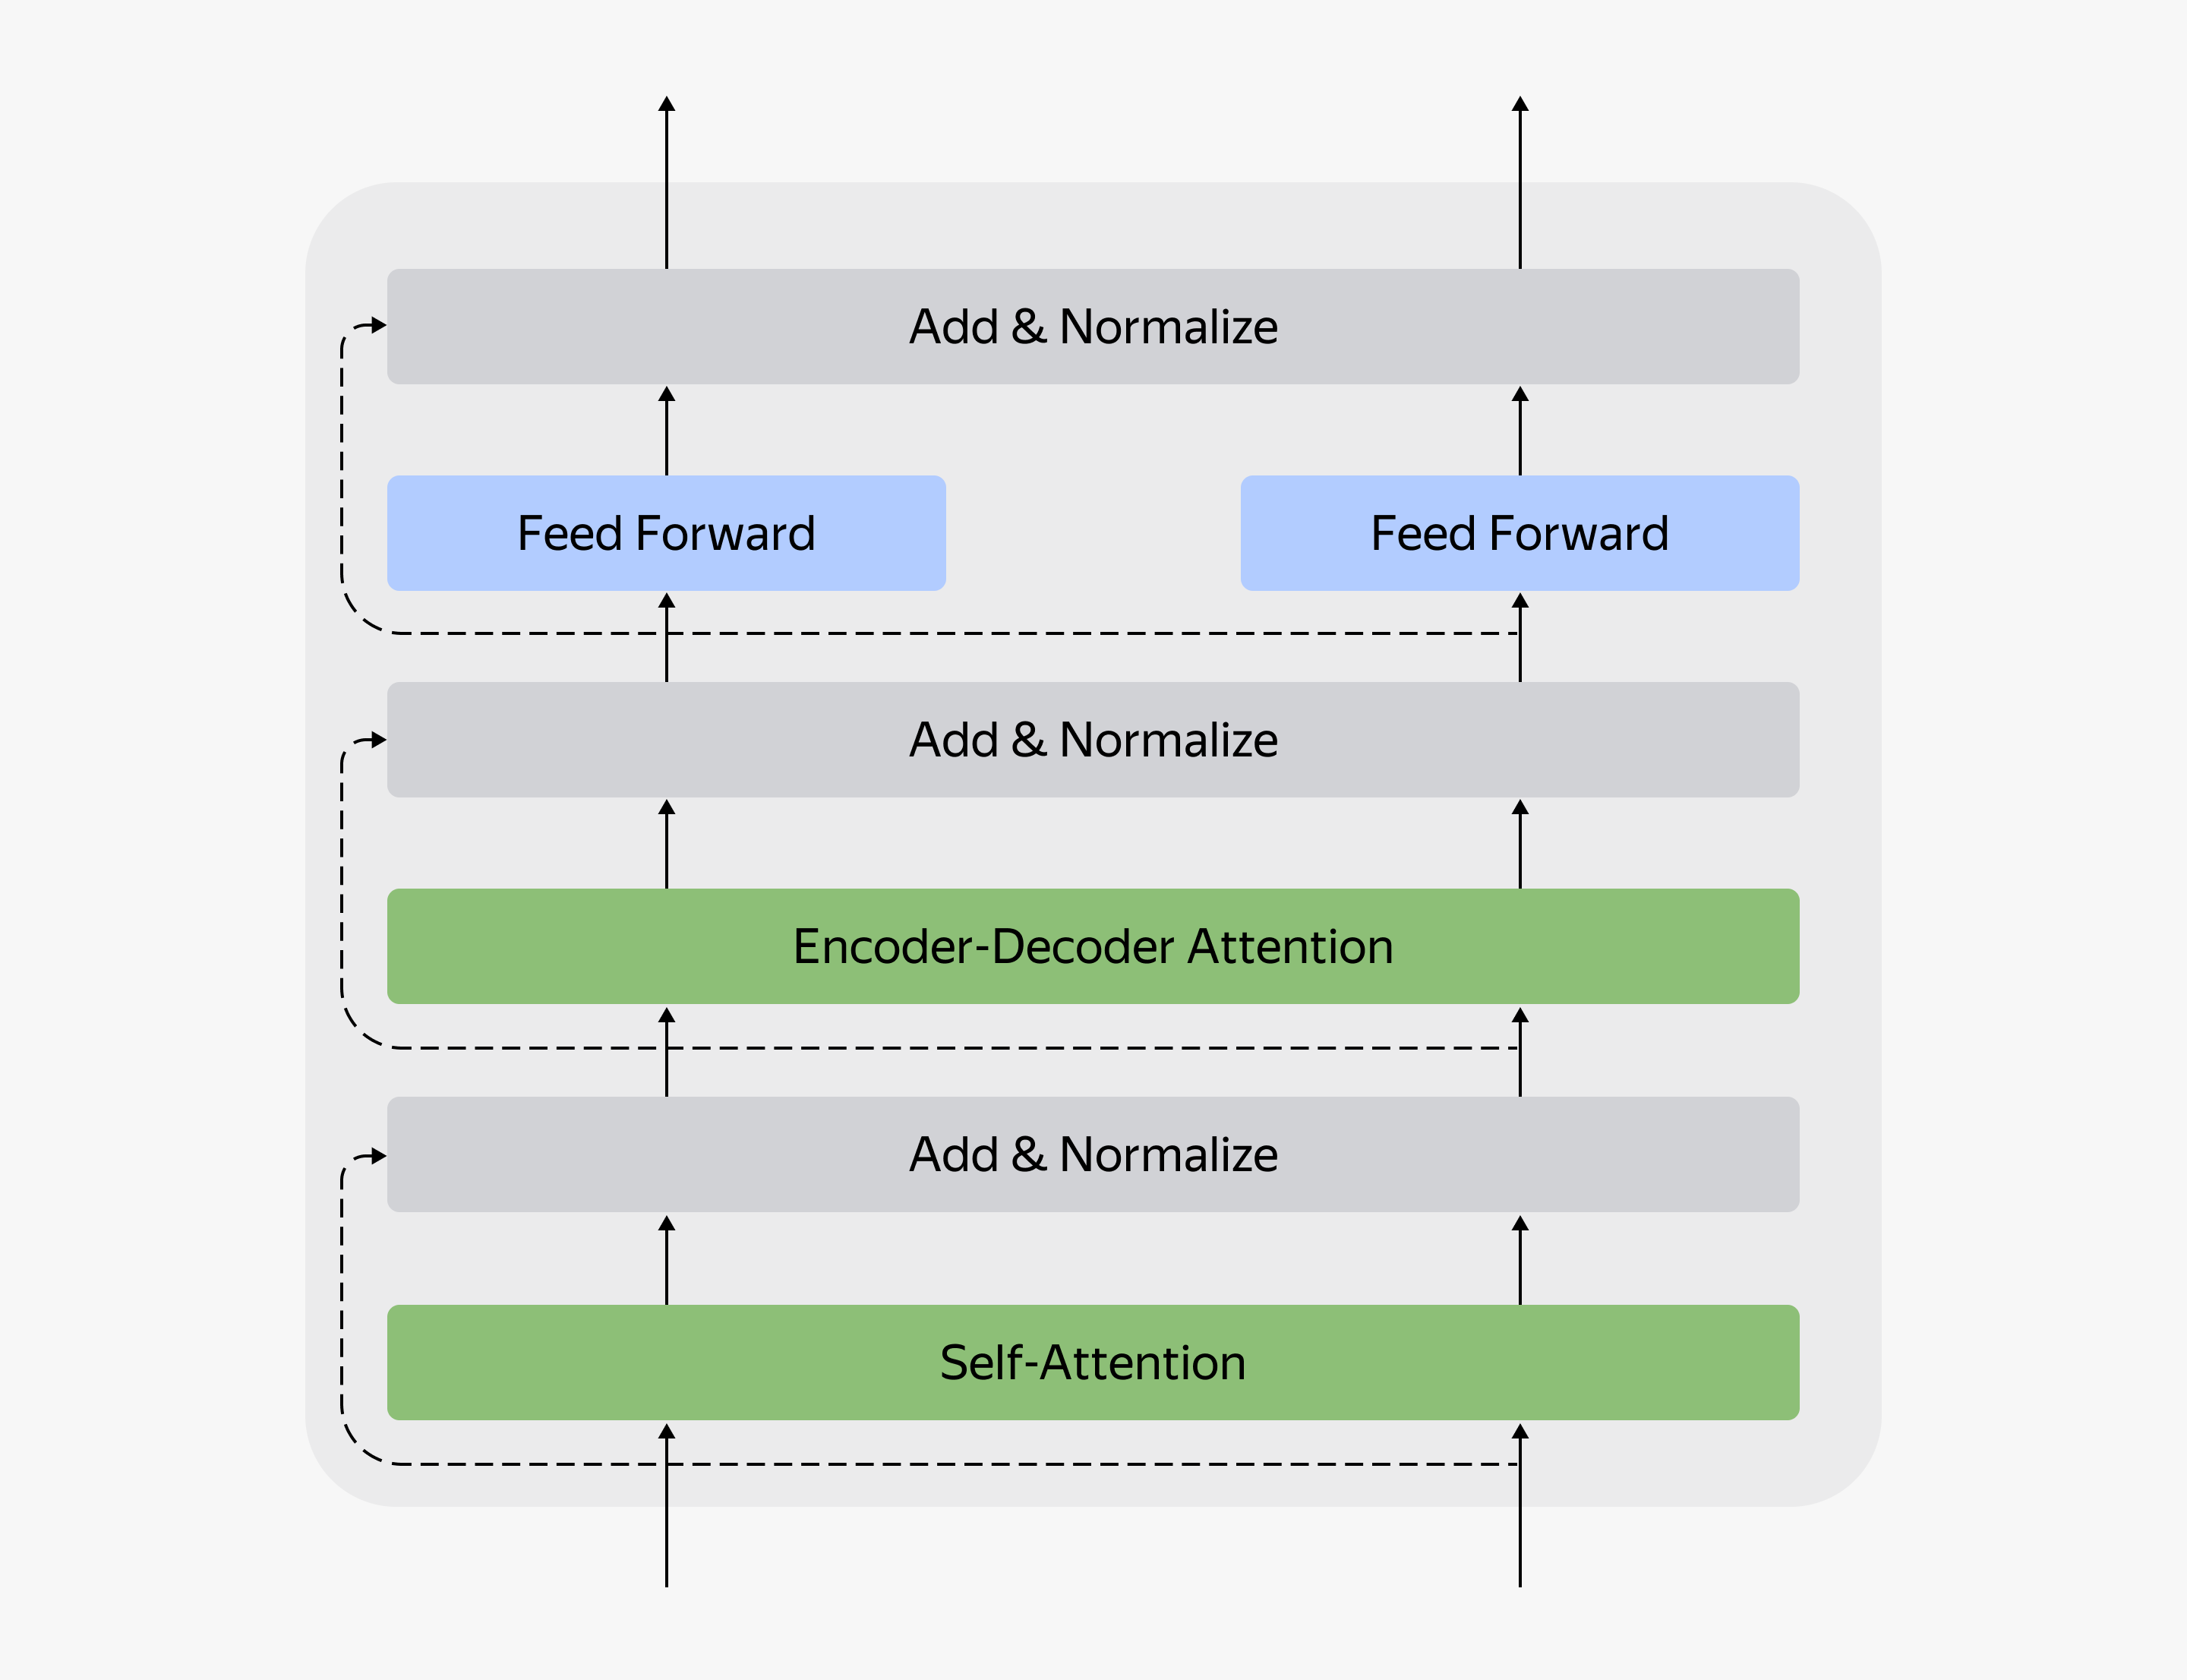

In [6]:
path_to_image: str = settings.SOURCE_PATH + "ml_dl/RNN/transformer_decoder.png"

Image(path_to_image, width=700, height=1000)

## Объединим все в единую картину:

1. На вход приходит последовательность токенов. 

К её численным представлениям добавляются векторы, хранящие в себе информацию о позициях токенов. 
Это **positional encoding**.

2. Полученные на предыдущем шаге представления токенов проходят последовательно через блоки энкодера. В каждом блоке для них:

 - Считается self-attention, что позволяет модели запоминать взаимосвязи между токенами.

 - Применяется линейный слой.
 
 - Вокруг слоёв используются Residual connection и нормализации для стабилизации обучения.

3. После прохождения блоков энкодера начинает работать декодер:
        
- Берёт уже сгенерированную последовательность — в самом начале это просто один специальный токен `<bos>` begining of sequence.

- Проводит её через блоки декодера с masked self-attention, encoder-decoder attention и линейными слоями.

- В конце к полученным представлениям применяется линейный слой и softmax, то есть для каждого токена из сгенерированной последовательности считается вектор размера vocab_size.

- По позиции токена с наибольшим результатом softmax'а выбирается следующий токен, который будет сгенерирован.

- Выбранный токен добавляется в сгенерированную последовательность, и декодер снова отрабатывает полный цикл генерации.

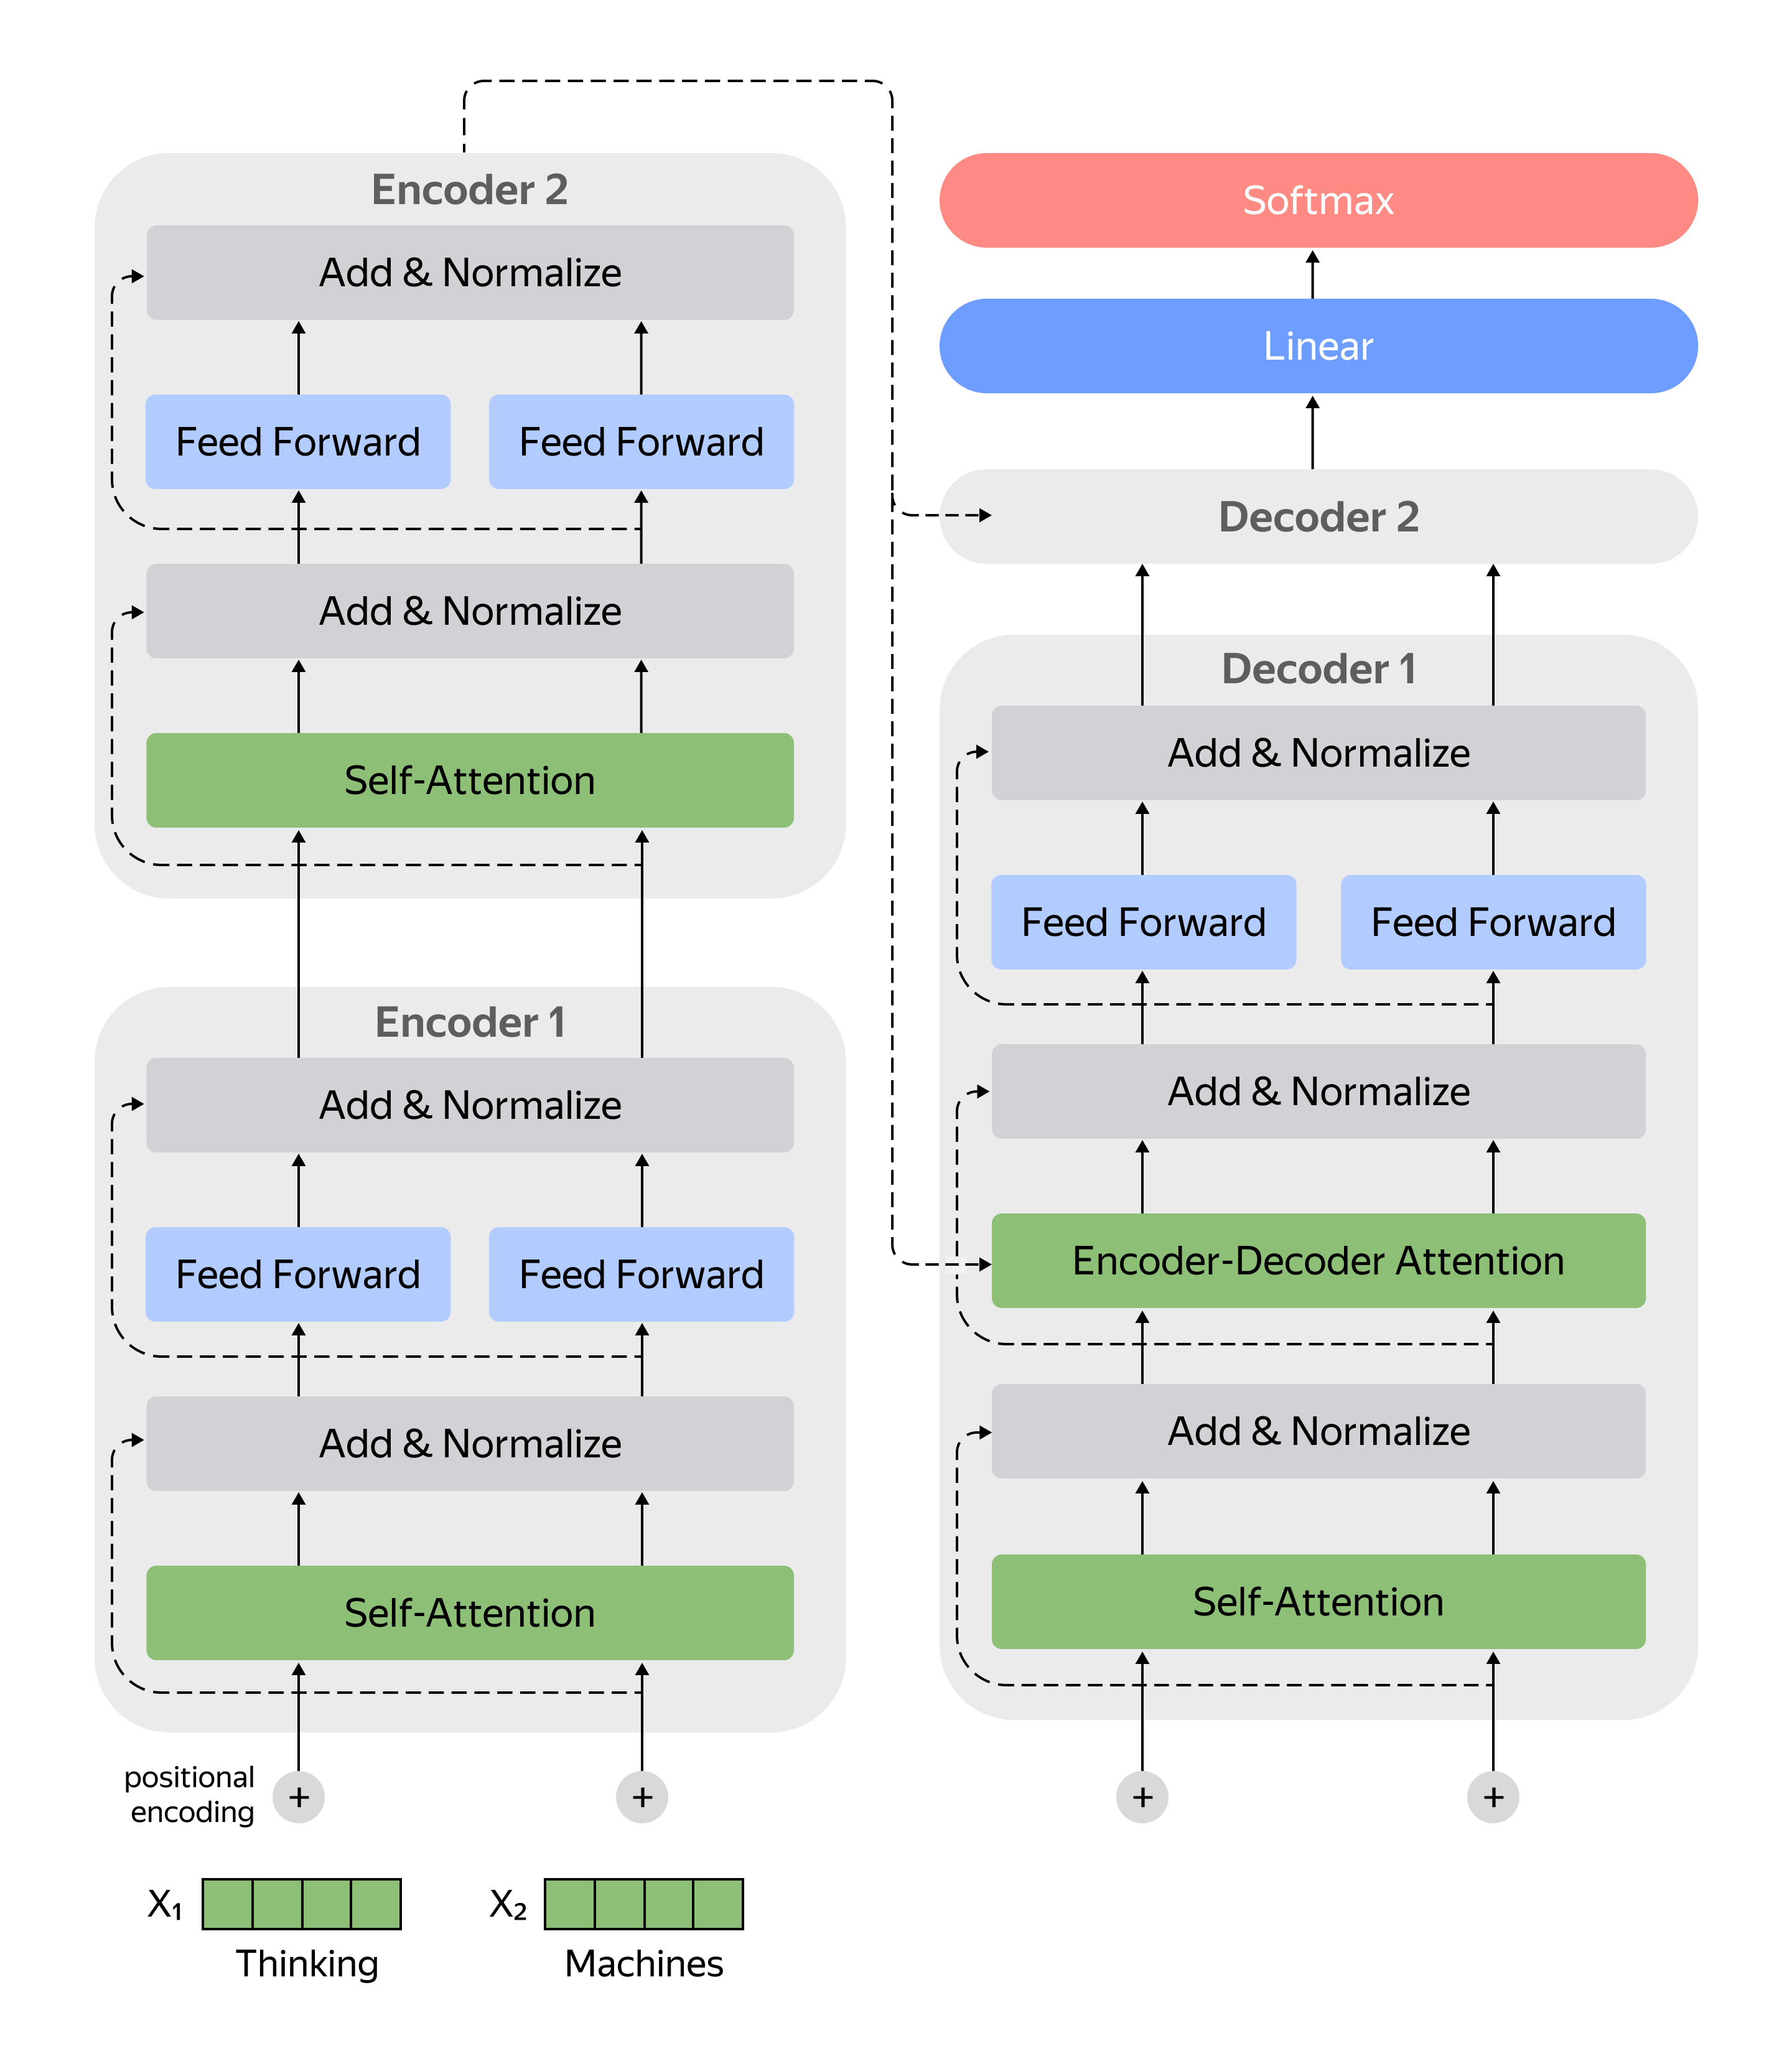

In [9]:
path_to_image: str = settings.SOURCE_PATH + "ml_dl/RNN/transformer_all.png"

Image(path_to_image, width=500, height=700)

# Задача суммаризации

>**Суммаризация** — это задача в области обработки естественного языка (NLP), цель которой — сжать исходный текст, сохранив при этом его основную суть. Модель должна понять, какие части текста являются ключевыми, и сформулировать краткое содержание.

Существует два типа суммаризации:

- Экстрактивная суммаризация (extractive summarization) — выбирает ключевые предложения из оригинального текста (без переформулирования) и составляет краткое содержание из них.
    
- Абстрактная суммаризация (abstractive summarization) — переформулирует ключевые идеи своими словами, как это делает человек.

Суммаризация может выглядеть очень краткой (2-3 предложения), а может быть и большой (несколько абзацев). Это зависит от размера суммаризируемого текста и требований решаемой задачи. В большинстве наиболее популярных задач тексты суммаризируются в совсем небольшой текст, обычно это не больше 3-4 предложений.

Экстрактивная суммаризация:

```text
Оригинал:

Машинное обучение — это область, в которой используются алгоритмы для автоматического выявления закономерностей в данных и принятия решений на их основе. Она активно применяется в рекомендациях, медицинской диагностике, финансовом анализе и других сферах.

Суммаризация:

Машинное обучение — это область выявления закономерностей в данных. Она применяется в рекомендациях, финансовом анализе и других сферах.
```

Абстрактная суммаризация:

```text
Оригинал:

Система распознавания речи преобразует звуковые сигналы в текстовую форму. Это позволяет пользователям взаимодействовать с устройствами голосом.

Суммаризация:

Распознавание речи переводит голос в текст для голосового управления устройствами.
```

Суммаризация широко используется в:

- журналистике и медиа — автоматическое создание кратких новостных заголовков и анонсов;
  
- юриспруденции — сжатие длинных юридических документов до ключевых положений;

- медицине — резюмирование медицинских записей, выписок пациентов;

- поддержке клиентов — краткие итоги диалогов с клиентами;

- исследованиях и образовании — автосаммари научных статей или лекций.

Это лишь часть возможных применений. Суммаризация помогает везде, где полезно ужать информацию, сохранив основную суть.

## Замер качества суммаризации

В задачах, где не просто надо предсказать число или класс, а сгенерировать текст, с ходу может быть не очень понятно, как замерять качество. Для этого существуют определённые метрики, замеряемые в задачах суммаризации, перевода текстов, генерации ответов и остальных задачах на генерацию текстов.

## Познакомимся с одной такой метрикой и замерим её в сегодняшней практике.

ROUGE (Recall-Oriented Understudy for Gisting Evaluation) — это метрика, которая сравнивает сгенерированный моделью текст с эталонным текстом (написанным человеком), измеряя степень совпадения фраз и слов.

Наиболее популярные варианты:

- ROUGE-1 — доля совпадающих слов;
  
- ROUGE-2 — доля совпадающих биграмм (пар слов);
    
- ROUGE-L — наибольшая общая подпоследовательность (Longest Common Subsequence).

Вот пример, как посчитать метрику ROUGE, используя библиотеку evaluate:

In [2]:
from evaluate import load

# Загружаем метрику
rouge = load("rouge")

# Списки с предсказанными и эталонными суммаризациями (референсными)
predictions = [
    "The cat sat on the mat and looked around."
]

references = [
    "A cat was sitting on the mat and observing the surroundings."
]

# Вычисляем метрику
results = rouge.compute(predictions=predictions, references=references)

# Печатаем значения
if isinstance(results, dict):
    for key, value in results.items():
        print(f"{key}: {value:.4f}")
else:
    print("Error")

rouge1: 0.6000
rouge2: 0.3333
rougeL: 0.5000
rougeLsum: 0.5000


# Использование предобученных трансформеров

Предобученные трансформеры проще и удобнее всего использовать из библиотеки transformers от HuggingFace.

В этом задании по суммаризации мы будем пользоваться моделью от Google с названием t5-base. На странице модели можно найти базовую информацию о ней — метод тренировки, количество параметров, поддерживаемые языки, ссылки на статьи, примеры использования и многое другое.

Загрузить модель и токенизатор для неё можно так:

In [1]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from ml_dl_experiments.settings import settings


model_name = settings.SOURCE_PATH+"ml_dl/models/t5-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

In [5]:
# Проверка работы модели
input_text = "translate English to German: Hello, how are you?"
inputs = tokenizer(input_text, return_tensors="pt")
outputs = model.generate(**inputs)
decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)

print(f"Input: {input_text}")
print(f"Output: {decoded}")

Input: translate English to German: Hello, how are you?
Output: Hallo, wie sind Sie?


In [6]:
# Текст для суммаризации
text = """
Machine learning is a field of artificial intelligence that uses statistical techniques to give computer systems the ability to learn from data, without being explicitly programmed. It is widely used in recommendation systems, fraud detection, medical diagnosis, and more.
"""

# Добавляем префикс "summarize: " — это важно для T5!
input_text = "summarize: " + text

# Токенизация и генерация
input_ids = tokenizer.encode(input_text, return_tensors="pt", max_length=512, truncation=True)
summary_ids = model.generate(input_ids, max_length=50, min_length=10, length_penalty=2.0, num_beams=4, early_stopping=True)

# Декодируем результат
summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

print("Summary:", summary)

Summary: machine learning is a field of artificial intelligence that uses statistical techniques . it is widely used in recommendation systems, fraud detection, medical diagnosis .


**Разберём код подробнее:**

- Метод `tokenizer.encode` здесь токенизирует сообщение. Важно, чтобы он возвращал `PyTorch`-тензоры ``(return_tensors="pt")`` и обрезал последовательности ``(truncation=True)`` до длины 512 элементов ``(max_length=512)``, так как модель, с которой мы работаем, не может обрабатывать последовательности большей длины.

- Метод `model.generate` принимает на вход тензор (токенизированный текст):

1. Параметры `min_length` и `max_length` регулируют длину генерируемого текста.

2. `length_penalty` штрафует модель за слишком длинный текст.
        
3. `num_beams` регулирует вариативность модели — чем больше `num_beams`, тем более разнообразным будет получаться текст.
        
4. `early_stopping=True` позволяет быстрее генерировать текст. Он останавливает перебор возможных генерируемых токенов по достижению num_beams возможных вариантов.

- После генерации полученную последовательность нужно декодировать из токенов в обычный текст. Для этого используется метод `tokenizer.decode` с параметром `skip_special_tokens=True`, чтобы специальные токены, отвечающие за начало и конец последовательности, не попали в финальный текст.

## Суммаризация законопроектов

В качестве датасета в практической задаче будем использовать BillSum — это датасет, содержащий тексты законопроектов США и их краткие официальные описания, предназначенный для задачи абстрактивной суммаризации.

Для начала загрузим модель и токенизатор, а также посмотрим, как выглядят слои энкодера и декодера, посчитаем количество параметров в модели. От вас нужно лишь написать код загрузки.

In [7]:
# 1) Общая конфигурация
cfg = model.config
print("Model config:")
print(f"d_model={cfg.d_model}, num_layers={cfg.num_layers}, feed_forward_size={cfg.d_ff}")
print()

# 2) Блок энкодера
first_encoder_block = model.encoder.block[0]
print("Encoder block:")
print(first_encoder_block)
print()

# 3) Декодер — блоки с self-attention и cross-attention
first_decoder_block = model.decoder.block[0]
print("Decoder block:")
print(first_decoder_block)
print()

# 4) количество параметров
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")

Model config:
d_model=768, num_layers=12, feed_forward_size=3072

Encoder block:
T5Block(
  (layer): ModuleList(
    (0): T5LayerSelfAttention(
      (SelfAttention): T5Attention(
        (q): Linear(in_features=768, out_features=768, bias=False)
        (k): Linear(in_features=768, out_features=768, bias=False)
        (v): Linear(in_features=768, out_features=768, bias=False)
        (o): Linear(in_features=768, out_features=768, bias=False)
        (relative_attention_bias): Embedding(32, 12)
      )
      (layer_norm): T5LayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): T5LayerFF(
      (DenseReluDense): T5DenseActDense(
        (wi): Linear(in_features=768, out_features=3072, bias=False)
        (wo): Linear(in_features=3072, out_features=768, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
        (act): ReLU()
      )
      (layer_norm): T5LayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
)

Decoder block:
T5Block(
  (layer

In [8]:
from datasets import load_dataset
# Загружаем подмножество для быстрого теста
dataset = load_dataset(path=settings.SOURCE_PATH+"datasets/billsum", split="test[:50]")

# Пример

print("Example from dataset:")
print(dataset[0])

Example from dataset:
{'text': "SECTION 1. ENVIRONMENTAL INFRASTRUCTURE.\n\n    (a) Jackson County, Mississippi.--Section 219 of the Water \nResources Development Act of 1992 (106 Stat. 4835; 110 Stat. 3757) is \namended--\n        (1) in subsection (c), by striking paragraph (5) and inserting \n    the following:\n        ``(5) Jackson county, mississippi.--Provision of an alternative \n    water supply and a project for the elimination or control of \n    combined sewer overflows for Jackson County, Mississippi.''; and\n        (2) in subsection (e)(1), by striking ``$10,000,000'' and \n    inserting ``$20,000,000''.\n    (b) Manchester, New Hampshire.--Section 219(e)(3) of the Water \nResources Development Act of 1992 (106 Stat. 4835; 110 Stat. 3757) is \namended by striking ``$10,000,000'' and inserting ``$20,000,000''.\n    (c) Atlanta, Georgia.--Section 219(f)(1) of the Water Resources \nDevelopment Act of 1992 (106 Stat. 4835; 113 Stat. 335) is amended by \nstriking ``$25,000,00

In [9]:
# тексты и их референсные суммаризации
texts = [item['text'] for item in dataset]
references = [item['summary'] for item in dataset]

tokenized_texts = []

for text in texts:
    input_text = "summarize: "+ text
    tokenized_input_text = tokenizer.encode(
        input_text,
        return_tensors="pt", 
        max_length=512, 
        truncation=True,
        padding="max_length"
    )

    tokenized_texts.append(tokenized_input_text)

print('Example of tokenized text:')
print(tokenized_texts[0])

Example of tokenized text:
tensor([[21603,    10,   180,  3073,  9562,  1300, 13209,  7765, 13044, 11810,
          4090,    27, 12619,  4763, 13733,  6463, 25380,     5,    41,     9,
            61,  7714,  1334,     6, 14579,     5,    18,    18,   134,    15,
          4985,   204,  2294,    13,     8,  2336, 10179,  2958,  1983,    13,
          9047,    41, 16431,  7135,     5,  4678,  2469,   117, 11190,  7135,
             5,     3, 22954, 12703,    19, 21012,    18,    18,  5637,    16,
         29233,    41,    75,   201,    57, 11214,  8986,     3, 15757,    11,
          8722,    53,     8,   826,    10,     3,     2, 15757,  7714,  5435,
             6,  3041,   159,     7,    23,  1572,    23,     5,    18,    18,
          3174,  6610,    13,    46,  2433,   387,  1899,    11,     3,     9,
           516,    21,     8, 23458,    42,   610,    13,  3334, 20667,   147,
          7631,     7,    21,  7714,  1334,     6, 14579,     5,    31,    31,
           117,    11,  6

In [11]:
import torch
import evaluate
from tqdm import tqdm

generated_summaries = []

for inputs in tqdm(tokenized_texts):
    with torch.no_grad():
        summary_ids = model.generate(
            inputs, 
            max_length=128, 
            length_penalty=2.0, 
            num_beams=4, 
            early_stopping=True)

    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    generated_summaries.append(summary)

rouge = evaluate.load("rouge")

# Подсчёт метрик
results = rouge.compute(
    predictions=generated_summaries,
    references=texts)

if isinstance(results, dict):
    print('Metrics')
    for k, v in results.items():
        print(f"{k}: {v:.4f}")

# пример сгенерированного саммари
print('Summary example:')
print(generated_summaries[0])

100%|██████████| 50/50 [03:53<00:00,  4.68s/it]


Metrics
rouge1: 0.0741
rouge2: 0.0626
rougeL: 0.0707
rougeLsum: 0.0741
Summary example:
(a) Jackson county, mississippi.--provision of an alternative water supply and a project for the elimination or control of combined sewer overflows for Jackson county, mississippi . (b) Manchester, new hampshire.--Section 219(e)(3) of the Water Resources Development Act of 1992 is amended by striking $10,000,000'' and inserting $20,000,000''


# Трансформер как универсальная модель

Чтобы понять, как именно трансформер адаптируется под решение разных задач, посмотрим на несколько примеров.

## Классификация текста

Трансформером можно не только генерировать текст, но и классифицировать. Энкодер участвует в чтении входной последовательности и извлечении из неё полезных признаков, а декодер — в генерации. И при решении задачи декодер можно исключить из архитектуры и использовать только энкодер.

На вход энкодера подаётся последовательность токенов длины `seq_len`, `d` — размерность скрытых представлений. Тогда на выходе, после энкодера, получается матрица представлений размера `(seq_len, d)` — по одному скрытому представлению на каждый входной токен.

Для задачи классификации можно использовать скрытое представление одного из токенов. Если применить к этому скрытому представлению линейный слой `nn.Linear(d, num_classes)`, то получатся скоры для каждого из классов, а дальше можно применять `softmax` и предсказывать класс.

Но скрытое состояние какого токена использовать? Это можно организовать при обучении и сборе датасета. Например, добавлять специальный токен `[CLS]` в начале каждой входной последовательности и использовать его представление для классификации.

### Рассмотрим на примере

**Вход:**
```
[CLS] Это был замечательный фильм! [SEP]
```

Здесь токен `[CLS]` используется специально для задачи классификации, а токен `[SEP]` обозначает конец последовательности.

**Выход:**
Модель возвращает вектор признаков для токена `[CLS]`, который затем подаётся в линейный классификатор:

```python
logits = classifier(outputs.last_hidden_state[:, 0, :])
```

То есть токен `[CLS]` используется как агрегатор информации обо всей последовательности. После трансформера берётся его представление и к нему применяется классификационная «голова».

## Распознавание именованных сущностей (Named Entity Recognition, NER)

В этой задаче для каждого слова в предложении нужно определить, является ли оно именованной сущностью и какой именно. Например, найти имена людей во входной последовательности или пометить локации в тексте.

**Вход:**
```
Стадион клуба Манчестер Юнайтед находится в Манчестере, Англия
```

**Выход:**
```
Стадион[nonlocation] клуба[nonlocation] Манчестер[nonlocation] Юнайтед[nonlocation] находится[nonlocation] в[nonlocation] Манчестере[location], Англия[location]
```

Такую задачу можно рассматривать как классификацию каждого входного токена по отдельности — нужно определить, является ли токен именованной сущностью или нет. В таком случае можно использовать представления, полученные из энкодера: применить линейный слой `nn.Linear(d, num_classes)` ко всему выходу энкодера (то есть к матрице размера `(seq_len, d)`). Тогда на выходе получится матрица размера `(seq_len, num_classes)`, которую можно использовать как классификацию каждого элемента входной последовательности:

```python
logits = classifier(outputs.last_hidden_state)  # shape: (seq_len, num_labels)
```

Здесь, в отличие от классической классификации, не нужно использовать один специальный токен, а нужно использовать просто выход для всех входных токенов.

## Предсказание пропущенного слова

Здесь модель получает текст с замаскированным токеном и должна предсказать, какое слово было скрыто.

**Формат входа:**
```
[CLS] Барак [MASK] был президентом США. [SEP]
```

**Выход:**
Модель возвращает эмбеддинги всех токенов, затем на позиции `[MASK]` применяется классификатор на словарный запас:

```python
mask_position = input_ids == tokenizer.mask_token_id
logits = classifier(outputs.last_hidden_state[mask_position])
```

То есть это тоже классификация поверх представления одного из токенов, но в качестве этого токена используется специальный токен `[MASK]` — пропущенное в тексте слова. Так модель обучается на предсказание слов, которые были намеренно замаскированы. Обратите внимание, что здесь тоже используется лишь выход энкодера и декодер можно полностью исключить из архитектуры.

## Другие задачи

На этом список не заканчивается. Спектр задач, которые может решать трансформер, очень широкий, ведь изменять можно и архитектуру, и метод формирования датасета, и надстройки поверх энкодера или декодера. И не стоит забывать, что по умолчанию трансформер решает seq2seq-задачу и всё, что связано с генерацией текстов, ему под силу.

## Трансформер как основа современных LLM

Возможности self-attention, масштабируемость и параллелизация архитектуры трансформера позволили ей стать основой больших языковых моделей как ChatGPT, PaLM, LLaMA, Mistral, Claude и многих других. Эти модели способны выполнять задачи от генерации текстов и перевода до написания кода и анализа данных. Трансформер масштабировали и продолжают масштабировать, получая всё более умные модели.

Уже сейчас понятно, что при увеличении размера модели, объёма данных и времени обучения производительность нейросетей на базе трансформера постоянно улучшается, особенно на сложных обобщающих задачах.

Масштабируемость архитектуры дала возможность делать очень большие модели. Но как обучать эти модели? Давайте посмотрим на процесс обучения по этапам.

- **Этап 1.** Предобучение на большом корпусе (Pretraining). Модель обучается на текстах из интернета: Wikipedia, книгах, статьях, кодах, форумах и т. п. Единственная задача, которой она учится, — предсказывать следующий токен:

```text
Вход: "Машинное обучение — это"
Цель: "область" 
```

Это self-supervised обучение: не нужно специально собирать разметку, модель учится понимать язык, мир, логику.

В результате модель знает языковые закономерности, факты, стили речи, структуры кода и т. д.

- **Этап 2.** Файнтюнинг по инструкции (Instruction tuning). Здесь модель адаптируется к тому, чтобы выполнять инструкции в человекопонятном виде.

Например:
```text
Вопрос: Назови столицу Франции.
Ответ: Париж 
```

Для этого этапа обучения нужны специально размеченные датасеты. Данные берутся из открытых датасетов, а также часто размечаются вручную под конкретную модель.

После этого этапа модель становится лучше в ответах по формату «вопрос-ответ», больше ориентирована на пользователя. Именно это позволяет ей не просто понимать язык, но и уметь общаться.

- **Этап 3.** RLHF — обучение с подкреплением с участием человека (Reinforcement Learning with Human Feedback). На этом этапе модель дотюнивают до идеального состояния. Модель генерирует несколько ответов на вопрос, а затем люди выбирают наилучший. За наилучший ответ модель вознаграждается — и её веса адаптируются, чтобы выдавать ответ, близкий к наилучшему.
На этом этапе модель учится отвечать более полезно, в более правильном стиле — вести дружелюбный и продуктивный диалог.

# Задание 1. Модель для продолжения текста

In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from ml_dl_experiments.settings import settings

# 1) Загрузка токенизатора и модели
model_name = settings.SOURCE_PATH + "ml_dl/models/distilgpt2"          # лёгкая версия GPT-2
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

# 2) Создаём pipeline для генерации
generator = pipeline(
    task="text-generation",
    model=model,
    tokenizer=tokenizer,
    device=0  # -1 = CPU; 0 = первый GPU (если есть)
)

# 3) Исходный промпт
prompt = "The herd of pigs on the hillside begged Him to allow them to enter into them"

# 4) Генерируем продолжение
out = generator(
    prompt,
    max_length=80,       # итоговая длина (включая prompt)
    num_return_sequences=1,
    do_sample=True,      # стохастическая генерация
    top_p=0.95,          # nucleus sampling
    temperature=0.8
)

print(out[0]["generated_text"])

Device set to use cuda:0
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=80) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


The herd of pigs on the hillside begged Him to allow them to enter into them and he said: 'Don't leave them. You may not want to eat them.'



The men said: 'The herd of pigs are very large and are very large but they are the only ones who can eat them.
'If you want to be at peace with them, just keep these pigs out of your house.
'If you want to be at peace with them, just keep them from entering into them and they will take them away.
'If you want to be at peace with them, just keep them from entering into them and they will take them away.'
A group of men, from the village of Rulch, near the village of Rulch, from the village of Rulch, from the village of Rulch, from the village of Rulch, from the village of Rulch, from the village of Rulch, from the village of Rulch, from the village of Rulch, from the village of Rulch, from the village of Rulch, from the village of Rulch, from the village of Rulch, from the village of Rulch, from the village of Rulch, from the village of Rulch,


## Задание 2. Модель для ответа на вопросы

Для генерации ответа на вопросы возьмём другую модель, специально обученную для этого. Ниже в переменной `context` записан текст. 
Выполняйте задание локально: скопируйте код, дополните его — придумайте вопрос по этому тексту. Запустите код и посмотрите, как модель ответит на вопрос.

In [ ]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, pipeline
from ml_dl_experiments.settings import settings

# 1) Загрузка токенизатора и модели
model_name = settings.SOURCE_PATH + "ml_dl/models/distilbert-base-uncased-distilled-squad"          
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForQuestionAnswering.from_pretrained(model_name)

# 1) Загружаем pipeline для вопросно-ответной задачи
qa_pipeline = pipeline(
    task="question-answering",
    model=model,
    tokenizer=tokenizer,
    device=0   # CPU
)

# 2) Пример входных данных
context = """
Transformers are neural network architectures introduced in 2017 by Vaswani et al. 
They rely entirely on self-attention mechanisms and have revolutionized natural language processing.
"""

question = "What is a transformers?"

# 3) Получаем ответ
result = qa_pipeline({
    "context": context,
    "question": question
})

print(f"Answer: {result['answer']}") #type:ignore

Device set to use cuda:0


Answer: neural network architectures


## Задание 3. Модель для классификации текста

В мире глубокого обучения есть много широко известных задач классификации, и для них тоже есть предобученные модели. Напишите ниже ваше мнение о каком-нибудь фильме, а модель решит, позитивный ваш отзыв или негативный.

In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from ml_dl_experiments.settings import settings

# 1) Загрузка токенизатора и модели
model_name = settings.SOURCE_PATH + \
    "ml_dl/models/rubert-tiny-sentiment-balanced"
          
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

classifier = pipeline(
    task="text-classification",
    model=model,
    tokenizer=tokenizer,
    device=0
)

text = "Я очень недоволен этим фильмом. Жаль потраченого времени"

result = classifier(text)

print(f"Метка: {result[0]['label']}, Уверенность: {result[0]['score']:.4f}")

Device set to use cuda:0


Метка: negative, Уверенность: 0.8620
